In [1]:
# using LinearAlgebra
using SparseArrays
# using Random
using CairoMakie
# using Statistics
# using ProgressMeter
using DataFrames
using StatsBase
using DelimitedFiles

In [2]:
include("EchoStateNetworksStochastic.jl")
using .EchoStateNetworksStochastic
include("ONReservoir.jl")
using .ONReservoir
include("TurningError.jl")
using .TurningError

In [3]:
ts_str = ["x", "y", "z"];

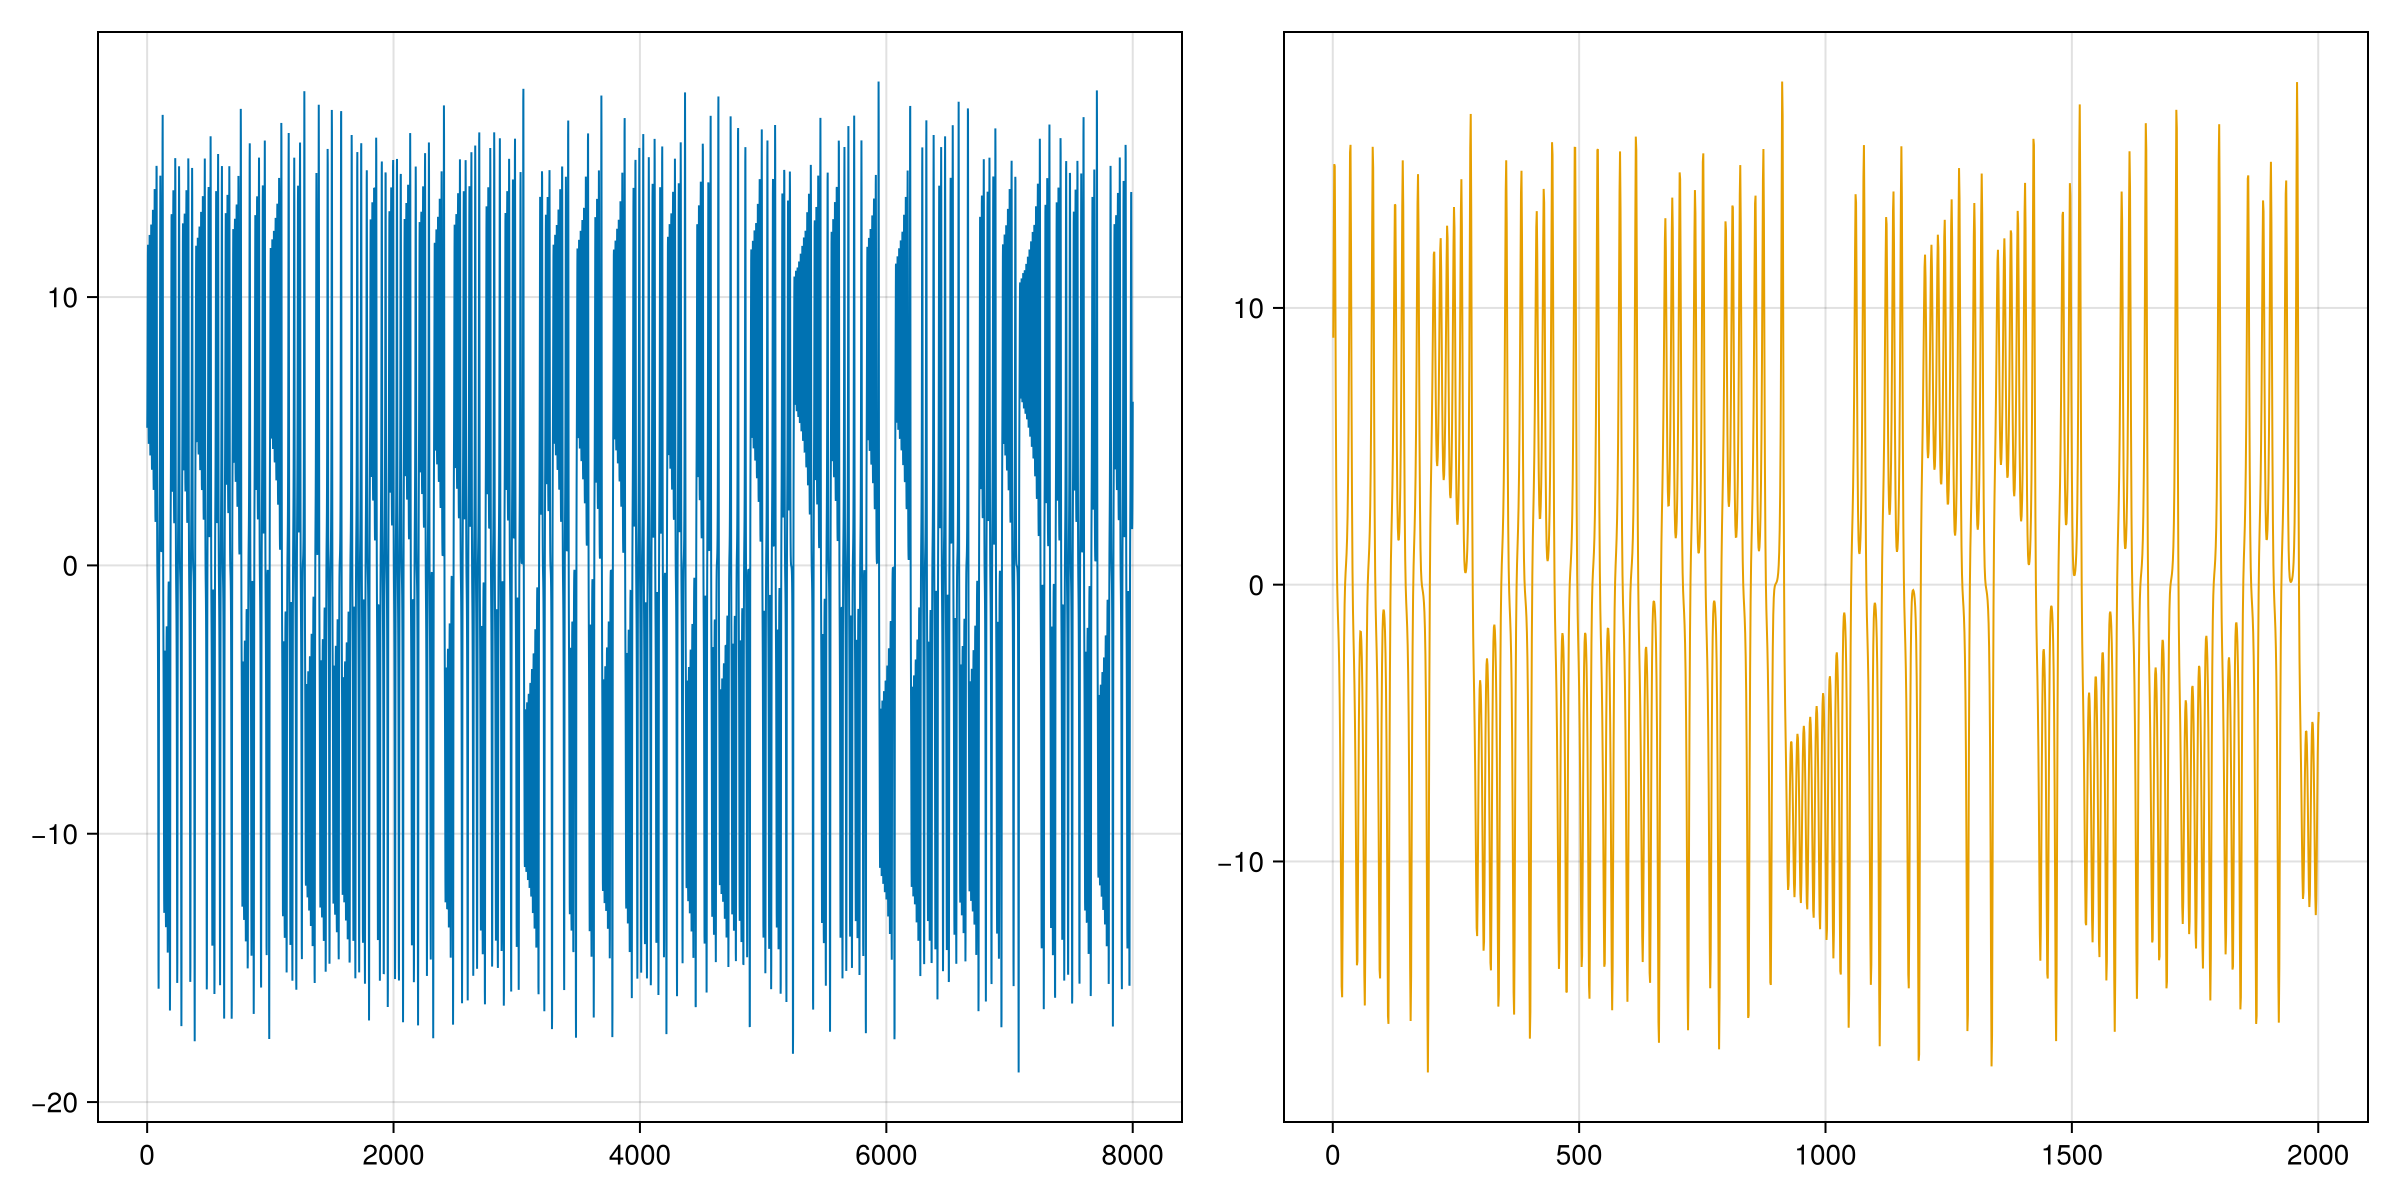

In [4]:
lo_train = vec(readdlm("lorenz_train.txt"))
lo_test = vec(readdlm("lorenz_test.txt"))

fig = Figure( size = (1200,600) )
lines!(Axis(fig[1,1]), lo_train; linewidth = 1.0, color = Cycled(1))
lines!(Axis(fig[1,2]), lo_test; linewidth = 1.0, color = Cycled(2))
fig

In [5]:
test_ON_part_adjacency = [
    0 0.1 0.2;
    0 0 0.3;
    0.4 0 0
]

k = 8
d = 3
ρ = 2.0
α = 1.0
η = 1/maximum(lo_train)
β = 0.001

ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=3, ON_part_set_connection=test_ON_part_adjacency)

DataFrame(ESN_params.V_rec, :auto)

24×24 DataFrame
 Row │ x1         x2        x3        x4        x5        x6        x7         ⋯
     │ Float64    Float64   Float64   Float64   Float64   Float64   Float64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.0        0.513691  0.0       0.0       0.0       0.0       0.0        ⋯
   2 │ 0.513691   0.0       0.0       0.0       0.0       0.0       0.0
   3 │ 0.0        0.0       0.0       0.0       0.799159  0.0       0.0
   4 │ 0.0        0.0       0.0       0.0       0.0       0.547861  0.0
   5 │ 0.0        0.0       0.799159  0.0       0.0       0.0       0.0        ⋯
   6 │ 0.0        0.0       0.0       0.547861  0.0       0.0       0.0
   7 │ 0.0        0.0       0.0       0.0       0.0       0.0       0.0
   8 │ 0.164435   0.0       0.0       0.173604  0.0       0.0       0.0
  ⋮  │     ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮       ⋱
  18 │ 0.0        0.0       0.0       0.0       0.0       0.0       0.0        ⋯
  19 │ 0.244291   0.0       0.0       0.0       0.0       0.0       0.0
  20 │ 0.0        0.0       0.0       0.0       0.0       0.0       0.873175
  21 │ 0.0150943  0.0       0.0       0.0       0.0       0.0       0.0
  22 │ 0.0        0.0       0.0       0.943617  0.0       0.0       0.478698   ⋯
  23 │ 0.0        0.0       0.0       0.0       0.0       0.0       0.0
  24 │ 0.0        0.0       0.0       0.0       0.0       0.0       0.0
                                                   17 columns and 9 rows omitted

In [7]:
m = 3
k = 4
part_connection=0.5
d = k*0.05
ρ = 1.2
α = 1.0
η = 1/maximum(lo_train)
β = 0.001
w = 1
τ = 2

window_size = (m-1)*τ
    
part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
num_partitions = length(unique_partitions_train)
# trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, ON_part_set_connection=trans_adjacency_matrix)

R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train, ON_part_adjacency=trans_adjacency_matrix)


part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
preds, test_states = one_step_pred(lo_test, ESN_params, R, S = train_states[end,:], partition_symbols=part_symbols_test, ON_part_adjacency=trans_adjacency_matrix)

([0.0, 0.0, 0.0, 0.0, 8.110919011652072, 4.536662032562646, 3.341604248879122, 0.7661058738705151, -0.691996682026172, -1.5467284366334013  …  -9.07502224826601, -10.640840026963005, -11.962154158661036, -12.543913872211306, -12.070248548153046, -8.255049488387556, -4.517519814195737, -3.3928987263617216, -3.746757367920736, -3.7813395781399493], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.7496669826152969 -0.12173228933312973 … -0.6733968852047721 -0.726992144111227; 0.7418708255760356 -0.10082300876052756 … -0.6733968852047721 -0.726992144111227])

In [8]:
trans_adjacency_matrix

6×6 Matrix{Float64}:
 0.865348   0.126675   0.00797703  0.0        0.0        0.0
 0.0        0.0340633  0.931873    0.0340633  0.0        0.0
 0.0        0.0        0.0577367   0.942263   0.0        0.0
 0.0        0.0        0.0         0.867003   0.127009   0.00598802
 0.0289157  0.0        0.0         0.0        0.0289157  0.942169
 0.955711   0.0        0.0         0.0        0.0        0.044289

In [9]:
DataFrame(ESN_params.V_rec, :auto)

24×24 DataFrame
 Row │ x1       x2       x3       x4       x5       x6       x7       x8       ⋯
     │ Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  ⋯
   2 │     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0
   3 │     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0
   4 │     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0
   5 │     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  ⋯
   6 │     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0
   7 │     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0
   8 │     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0
  ⋮  │    ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮     ⋱
  18 │     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  ⋯
  19 │     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0
  20 │     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0
  21 │     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0
  22 │     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  ⋯
  23 │     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0
  24 │     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0
                                                   16 columns and 9 rows omitted

In [10]:
function RMSE(y_true, y_pred)
    return sqrt(mean((y_true .- y_pred) .^ 2))
end

RMSE (generic function with 1 method)

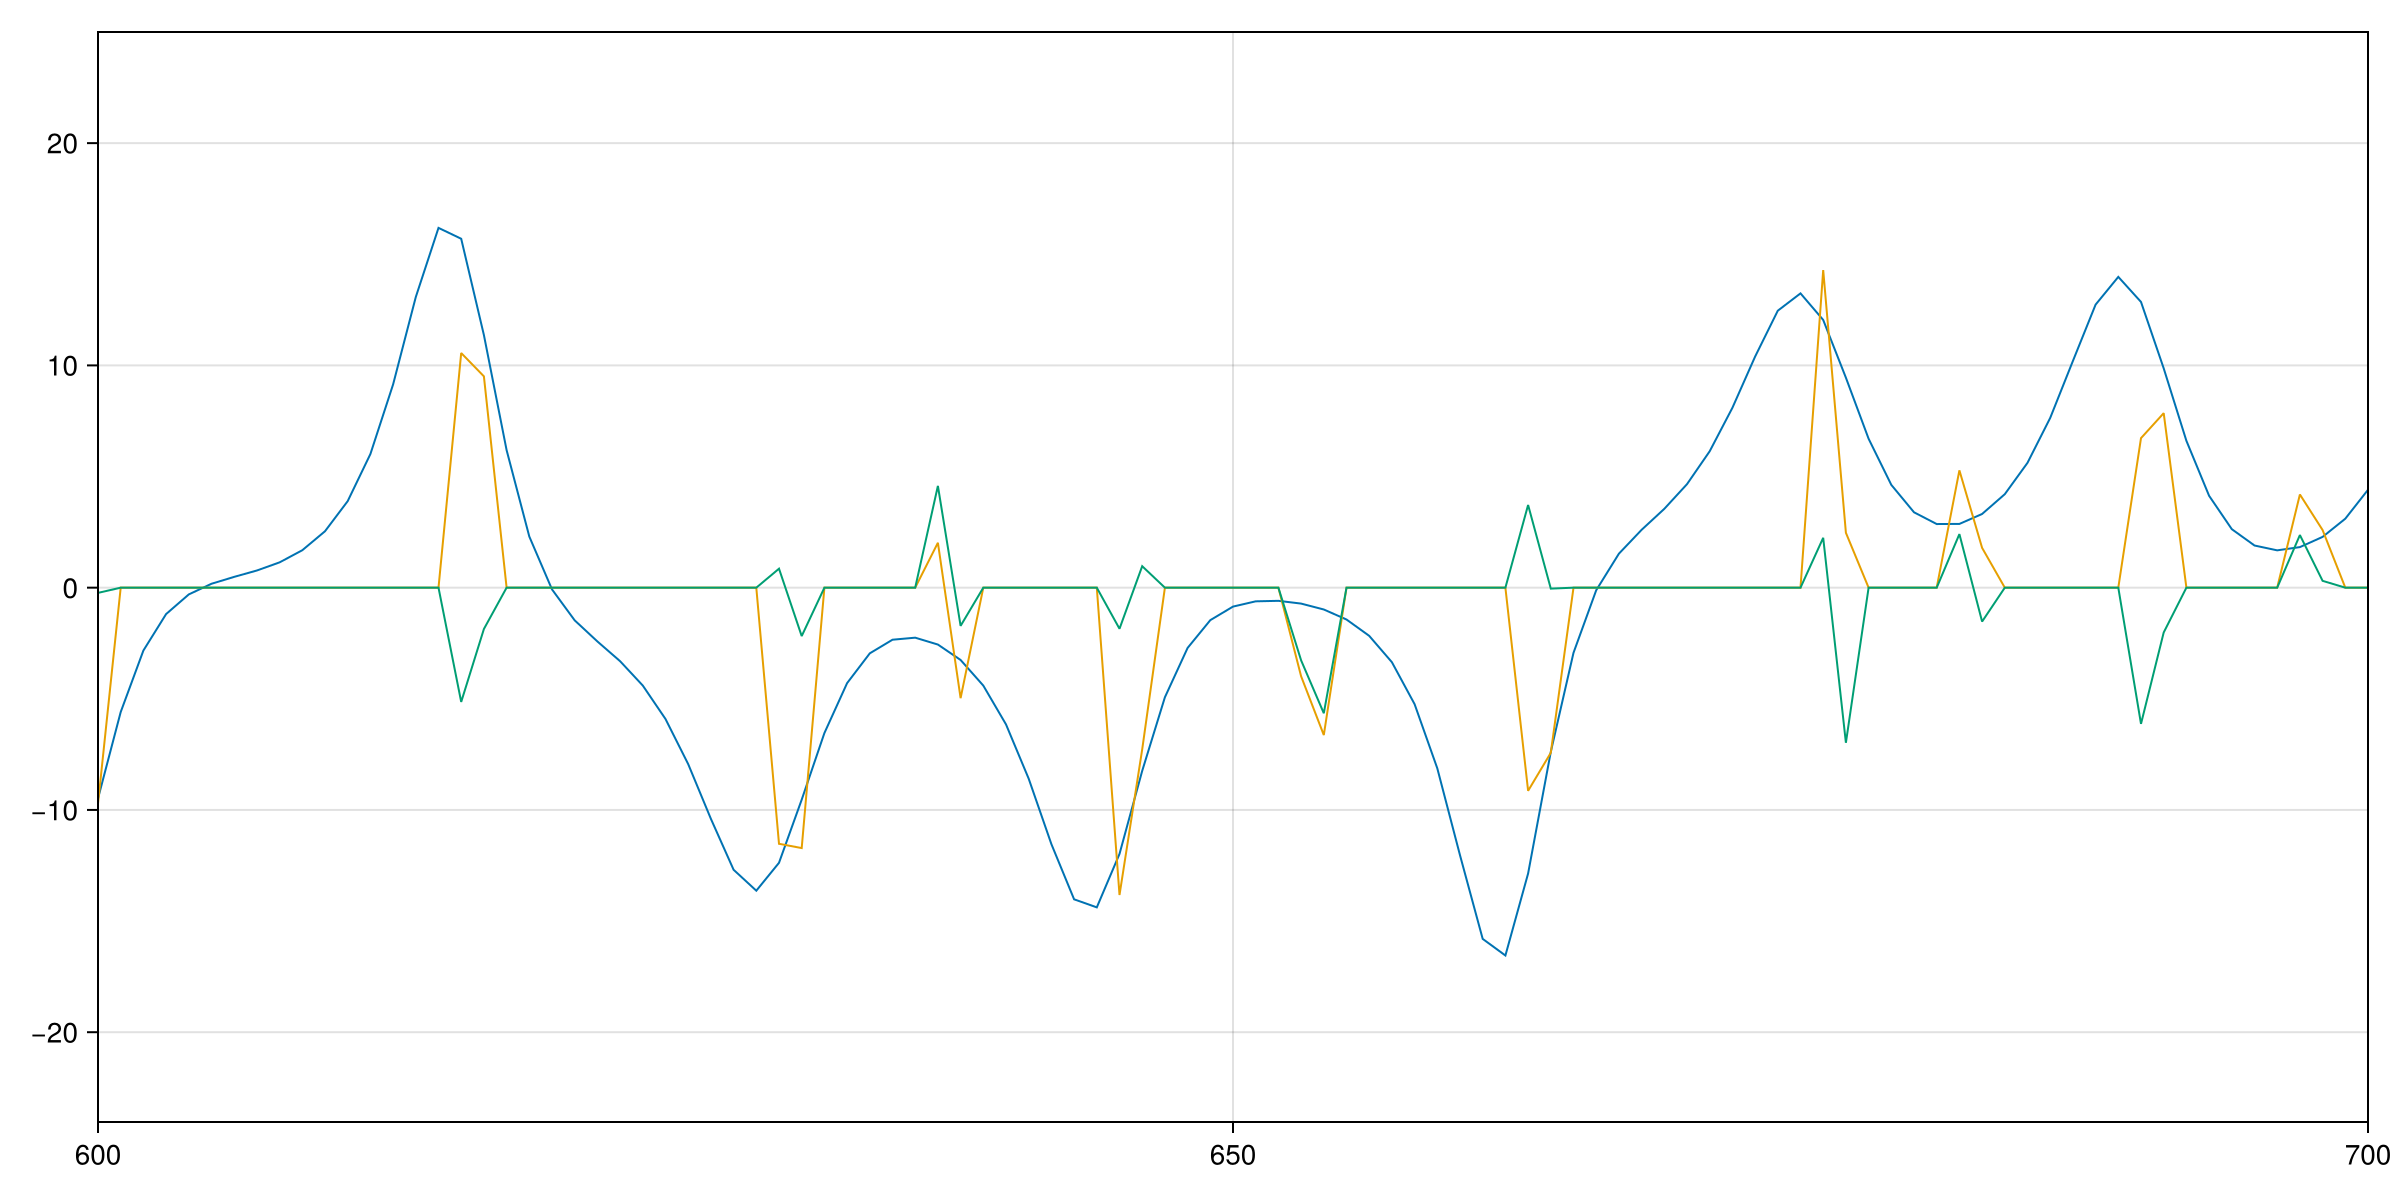

In [11]:
test_preds = lo_test + 3 * randn(length(lo_test))

test_mask = create_turning_partition_mask(lo_test, 4, 1, 1)
error = test_preds .- lo_test

fig = Figure( size = (1200,600))

ax1 = Axis(fig[1,1])
lines!(ax1, lo_test; linewidth = 1.0, color = Cycled(1))
lines!(ax1, test_preds .* test_mask; linewidth = 1.0, color = Cycled(2))
lines!(ax1, error .* test_mask; linewidth = 1.0, color = Cycled(3))

xlims!(600,700)

fig

In [12]:
function compare_preds(ON_preds, vanilla_preds, x_start, x_end; calculate_error=true, ignore_first=0, offset=1)
    ON_preds_cropped = ON_preds[ignore_first+1:end]
    vanilla_preds_cropped = vanilla_preds[ignore_first+1:min(length(ON_preds), end)]
    lo_test_cropped = lo_test[offset+ignore_first+1:min(length(ON_preds_cropped)+offset+ignore_first, end)]

    if calculate_error
        println("Ordinal network reservoir prediction RMSE: ", RMSE(ON_preds_cropped, lo_test_cropped))
        println("Vanilla prediction RMSE: ", RMSE(vanilla_preds_cropped, lo_test_cropped))
        println("Ordinal network reservoir prediction turning partition RMSE: ", turning_partition_RMSE(ON_preds_cropped, lo_test_cropped))
        println("Vanilla prediction turning partition RMSE: ", turning_partition_RMSE(vanilla_preds_cropped, lo_test_cropped))
    end

    fig = Figure( size = (1200,600))

    ax1 = Axis(fig[1,1])
    lines!(ax1, ON_preds_cropped; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test_cropped; linewidth = 1.0, color = Cycled(2))

    xlims!(x_start,x_end)
    ylims!(-25,25)

    ax2 = Axis(fig[1,2])
    lines!(ax2, vanilla_preds_cropped; linewidth = 1.0, color = Cycled(1))
    lines!(ax2, lo_test_cropped; linewidth = 1.0, color = Cycled(2))

    xlims!(x_start,x_end)
    ylims!(-25,25)

    fig
end

compare_preds (generic function with 1 method)

## Single step predictions

In [22]:
function create_pred_for_params(m; k = 100, part_connection=0.5, d = k*0.05, ρ = 1.2, α = 1.0, η = 1/maximum(lo_train), β = 0.001, w = 1, τ = 2)
    window_size = (m-1)*τ
    
    part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
    trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
    num_partitions = length(unique_partitions_train)
    # trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

    ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, ON_part_set_connection=trans_adjacency_matrix)

    R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train, ON_part_adjacency=trans_adjacency_matrix)

    println("Created reservoir of size: ", size(train_states[end,:]))

    part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
    preds, test_states = one_step_pred(lo_test, ESN_params, R, S = train_states[end,:], partition_symbols=part_symbols_test, ON_part_adjacency=trans_adjacency_matrix)

    return(preds[1:end-length(unique_partitions_test)])
end

create_pred_for_params (generic function with 1 method)

### Equal size of overall reservoir

#### 600 total size

In [23]:
# good candidate for multithreading
ON_preds = create_pred_for_params(3; k = 100, part_connection=0.5)
vanilla_preds = create_pred_for_params(1; k = 600)
;

Created reservoir of size: (600,)
Created reservoir of size: (600,)


Ordinal network reservoir prediction RMSE: 1.067292286736944
Vanilla prediction RMSE: 0.01632505176731453
Ordinal network reservoir prediction turning partition RMSE: 3.047860344833112
Vanilla prediction turning partition RMSE: 3.061265084039387


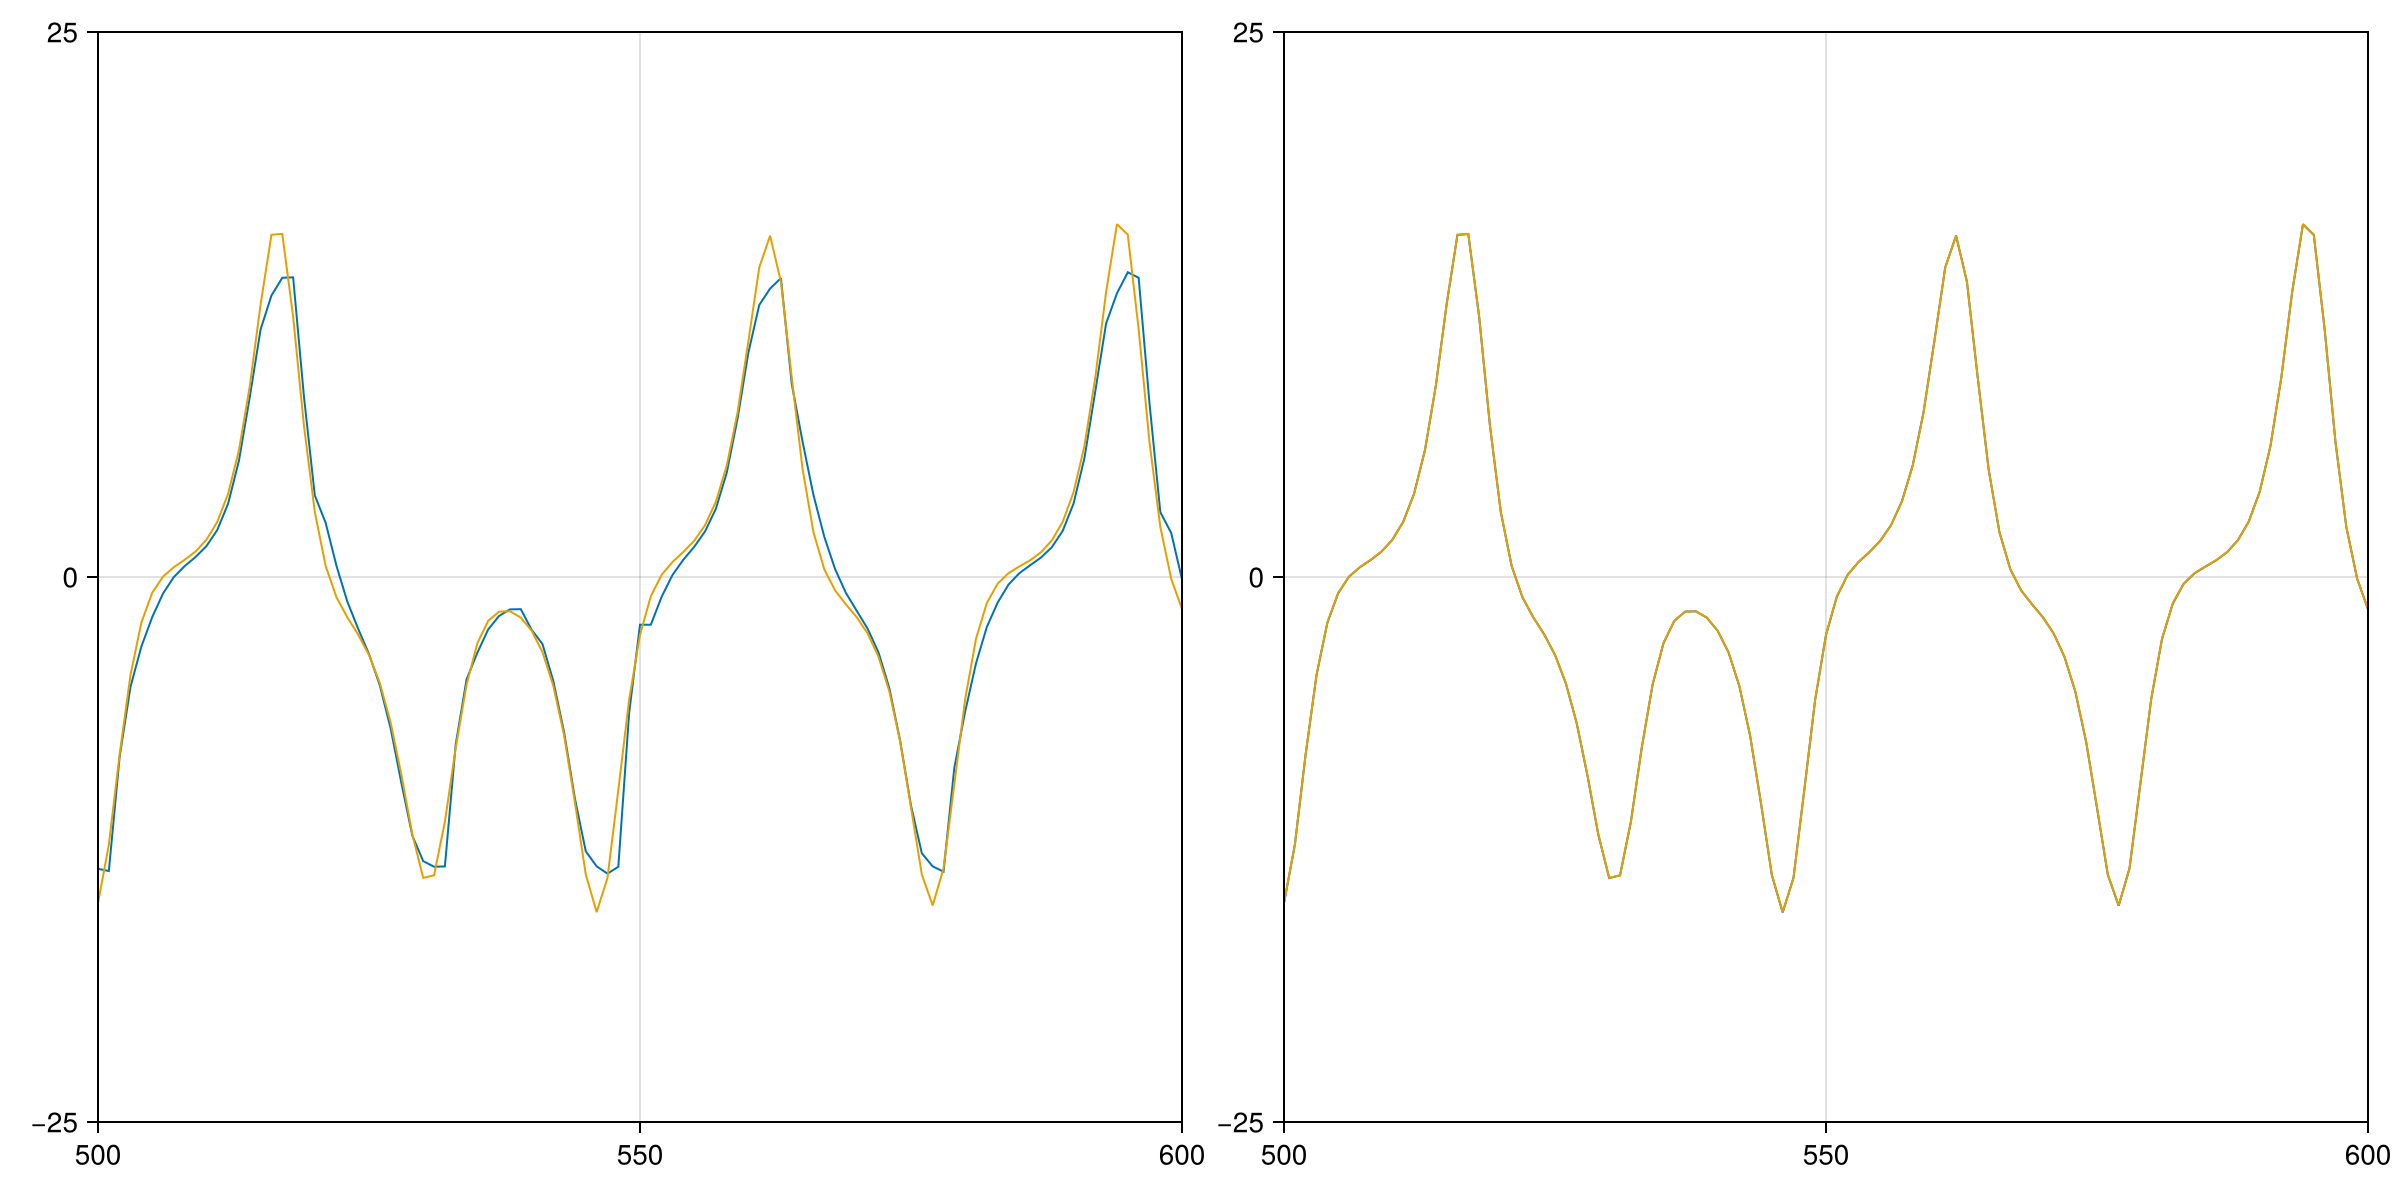

In [24]:
compare_preds(ON_preds, vanilla_preds, 500, 600, ignore_first=20)

#### 60 overall size

In [50]:
ON_preds = create_pred_for_params(3; k = 10, d=2, part_connection=0.5)
vanilla_preds = create_pred_for_params(1; k = 60)
;

Created reservoir of size: (60,)
Created reservoir of size: (60,)


Ordinal network reservoir prediction RMSE: 1.0021898488224352
Vanilla prediction RMSE: 0.3843630296366267
Ordinal network reservoir prediction turning partition RMSE: 2.9997153525260933
Vanilla prediction turning partition RMSE: 3.150470171640443


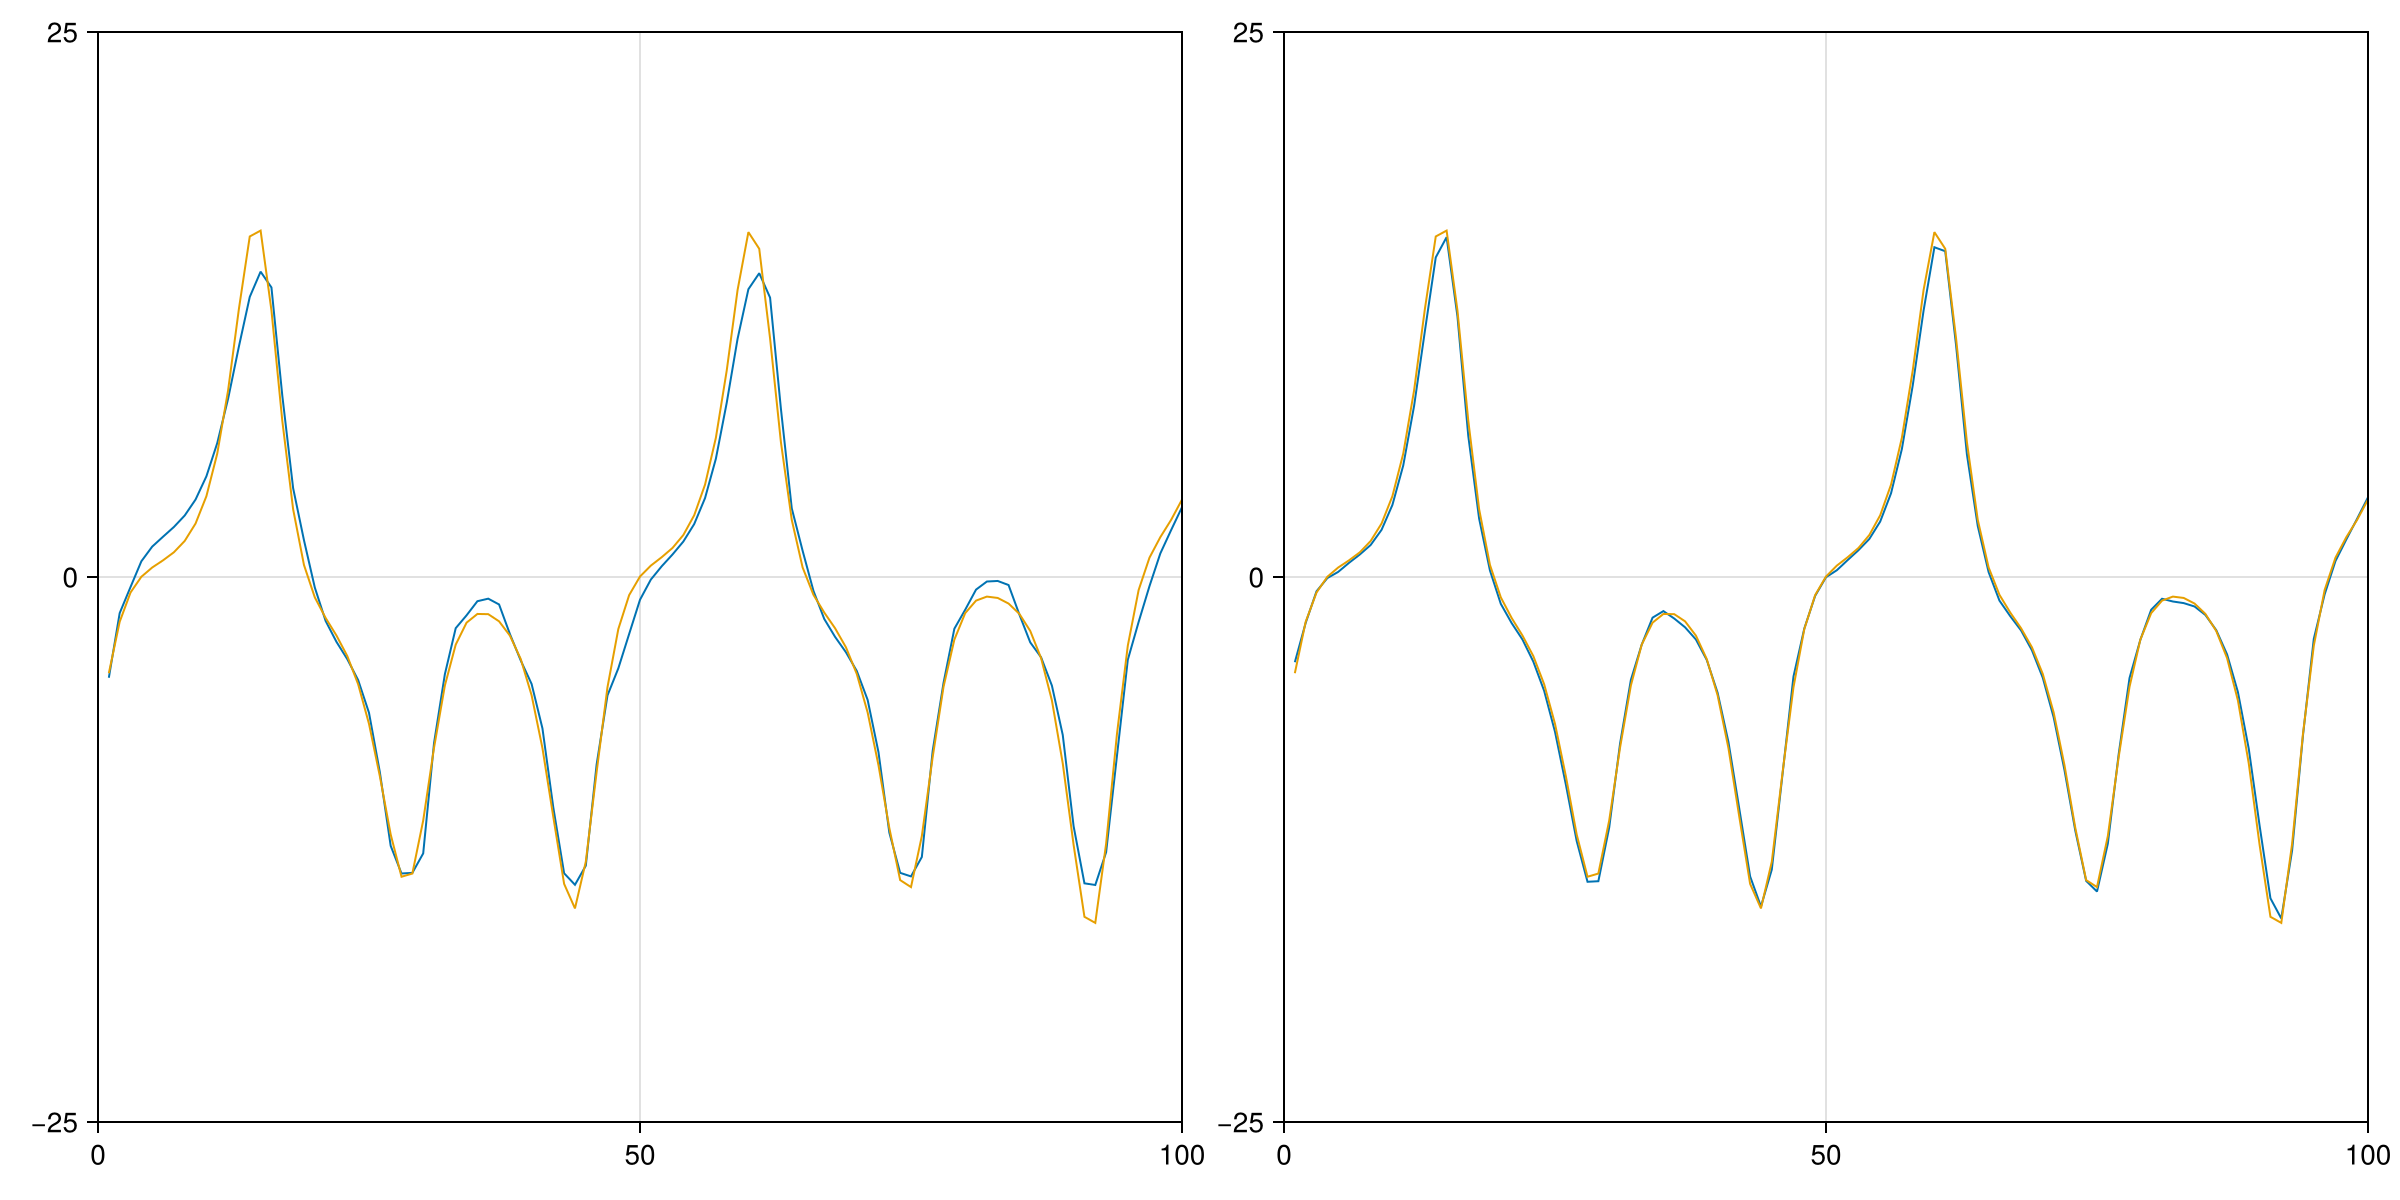

In [51]:
compare_preds(ON_preds, vanilla_preds, 0, 100, ignore_first=20)

### Equal k

#### k = 100

In [52]:
# good candidate for multithreading
ON_preds = create_pred_for_params(3; k = 100, part_connection=0.5)
vanilla_preds = create_pred_for_params(1; k = 100)
;

Created reservoir of size: (600,)
Created reservoir of size: (100,)


Ordinal network reservoir prediction RMSE: 0.2280079046199152
Vanilla prediction RMSE: 0.28022684973247824
Ordinal network reservoir prediction turning partition RMSE: 3.10935770415094
Vanilla prediction turning partition RMSE: 3.141252860507614


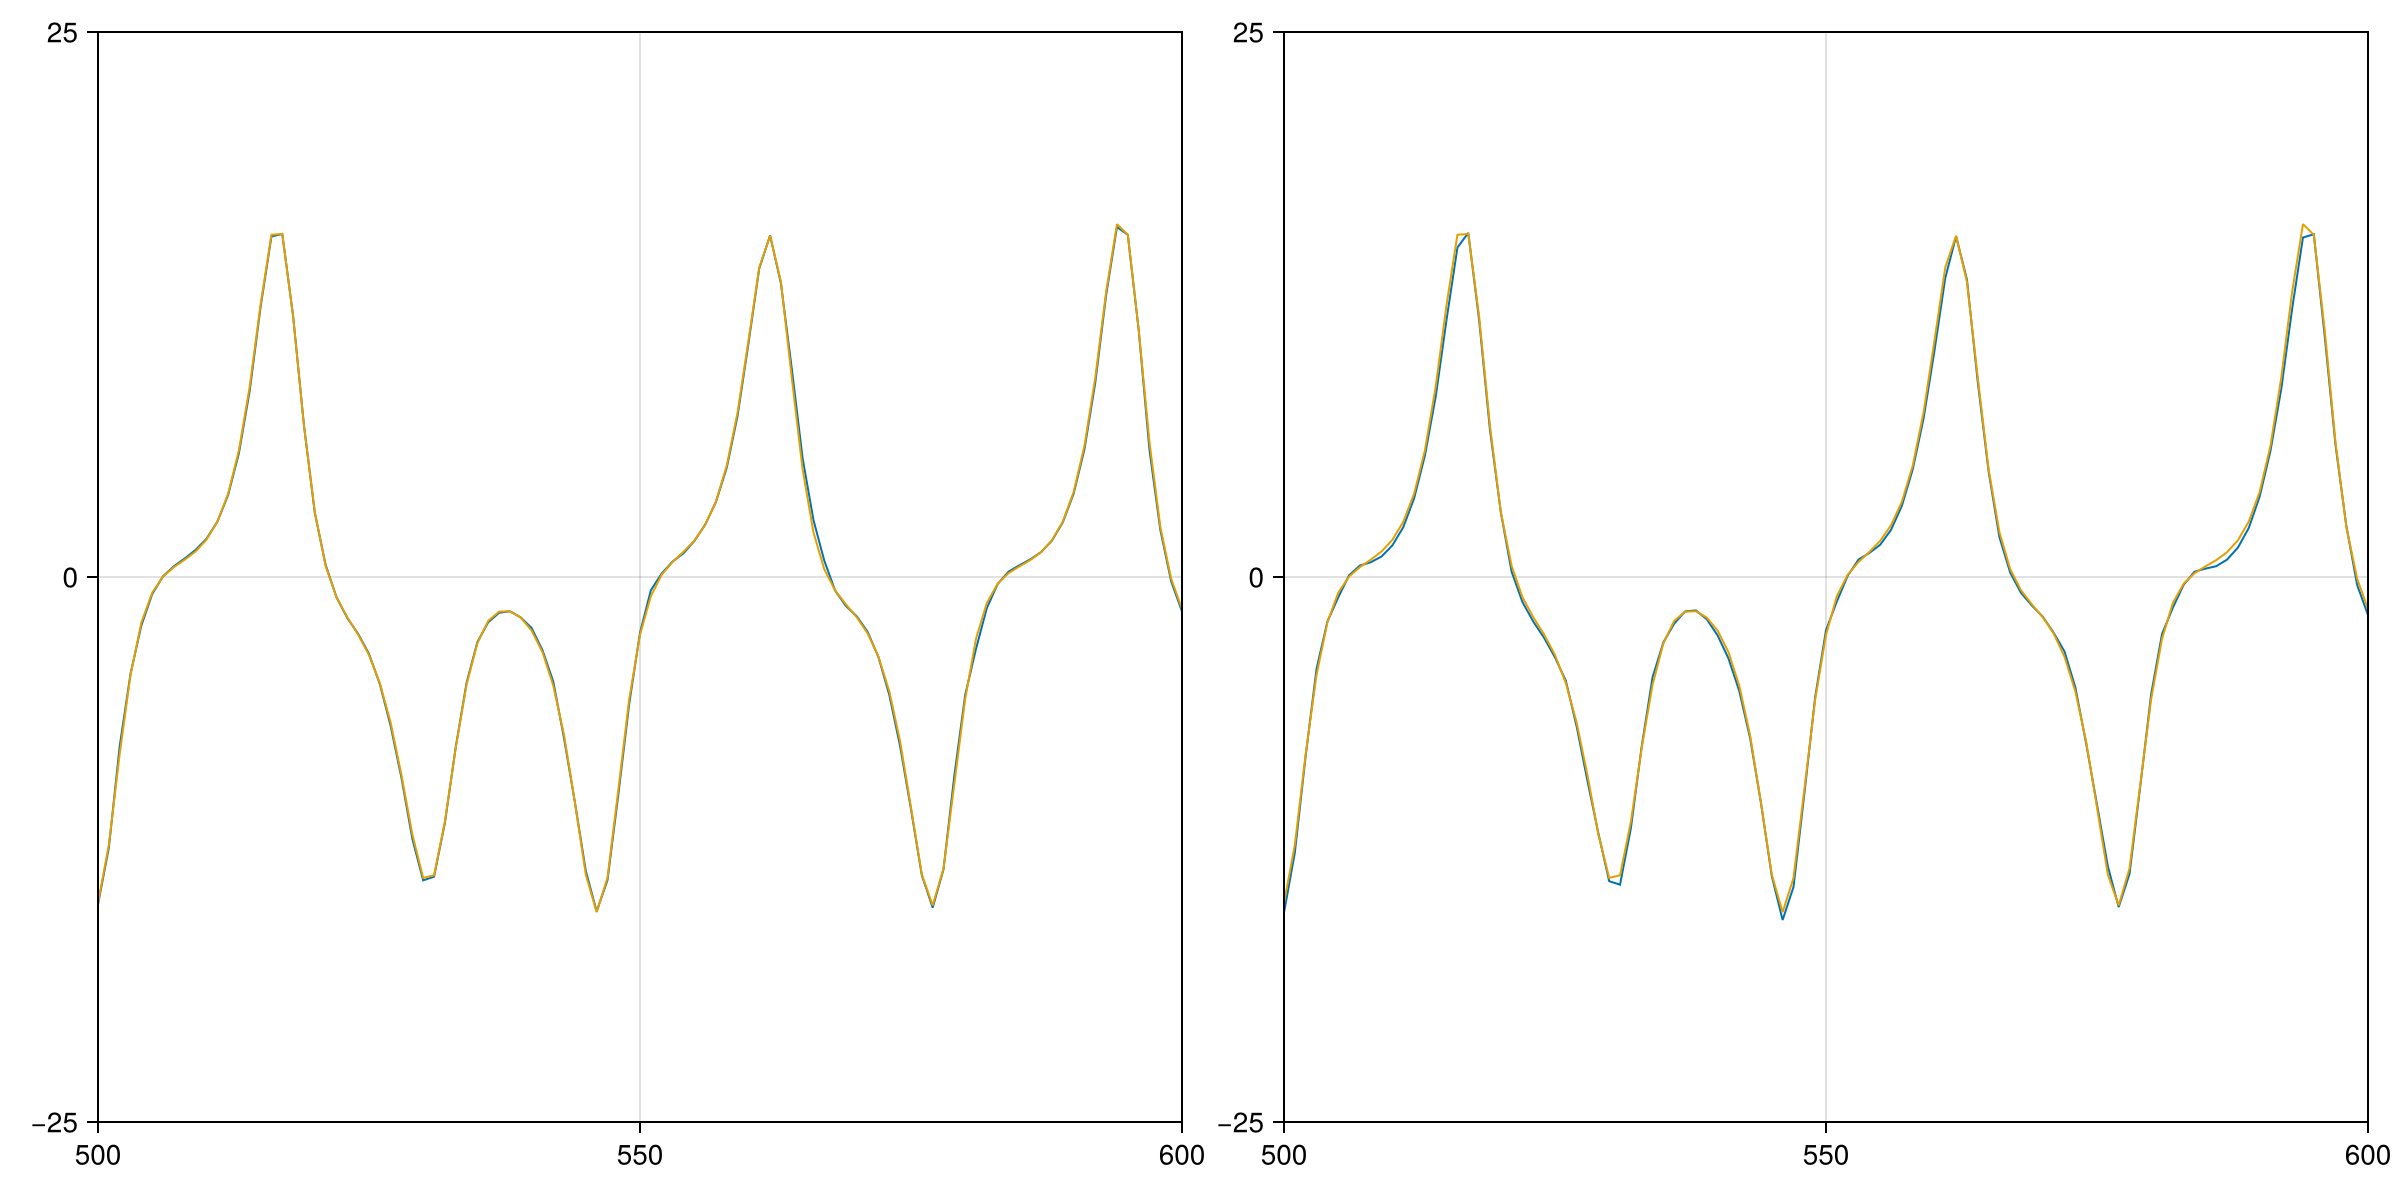

In [53]:
compare_preds(ON_preds, vanilla_preds, 500, 600, ignore_first=20)

#### k = 10

In [54]:
# good candidate for multithreading
ON_preds = create_pred_for_params(3; k = 10, part_connection=0.5)
vanilla_preds = create_pred_for_params(1; k = 10)
;

Created reservoir of size: (60,)
Created reservoir of size: (10,)


Ordinal network reservoir prediction RMSE: 0.8075247731712671
Vanilla prediction RMSE: 1.45999972642588
Ordinal network reservoir prediction turning partition RMSE: 3.2378925541354304
Vanilla prediction turning partition RMSE: 2.4450587741134284


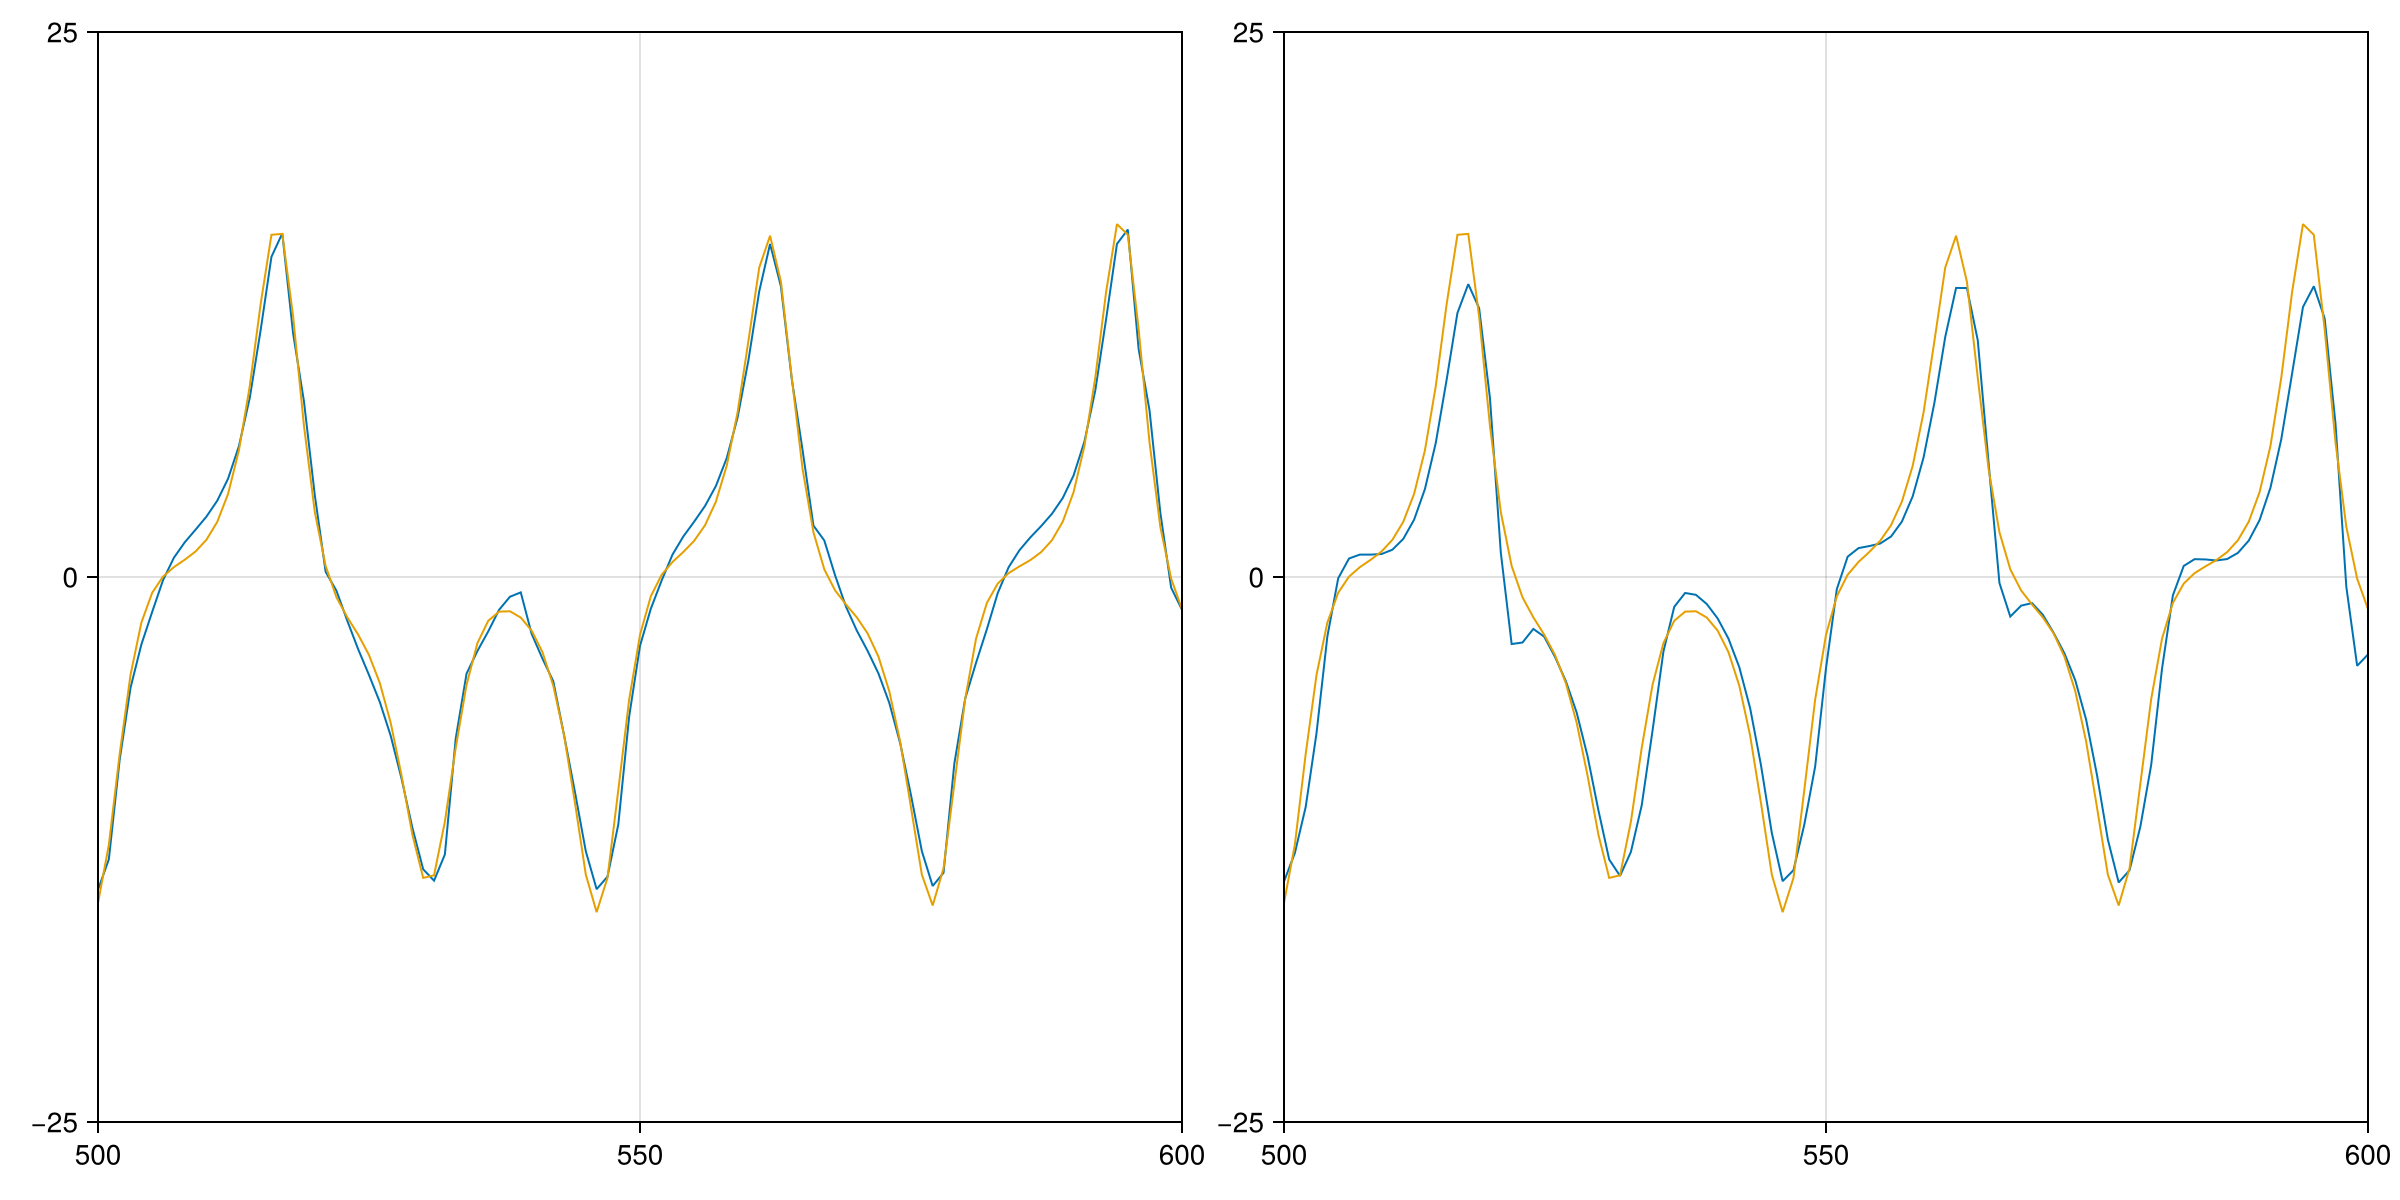

In [55]:
compare_preds(ON_preds, vanilla_preds, 500, 600, ignore_first=20)

#### k = 500

In [56]:
# good candidate for multithreading
ON_preds = create_pred_for_params(3; k = 500, part_connection=0.5)
vanilla_preds = create_pred_for_params(1; k = 500)
;

Created reservoir of size: (3000,)
Created reservoir of size: (500,)


Ordinal network reservoir prediction RMSE: 0.10362480284802589
Vanilla prediction RMSE: 0.0688844139552509
Ordinal network reservoir prediction turning partition RMSE: 3.077970301318875
Vanilla prediction turning partition RMSE: 3.0640692414249


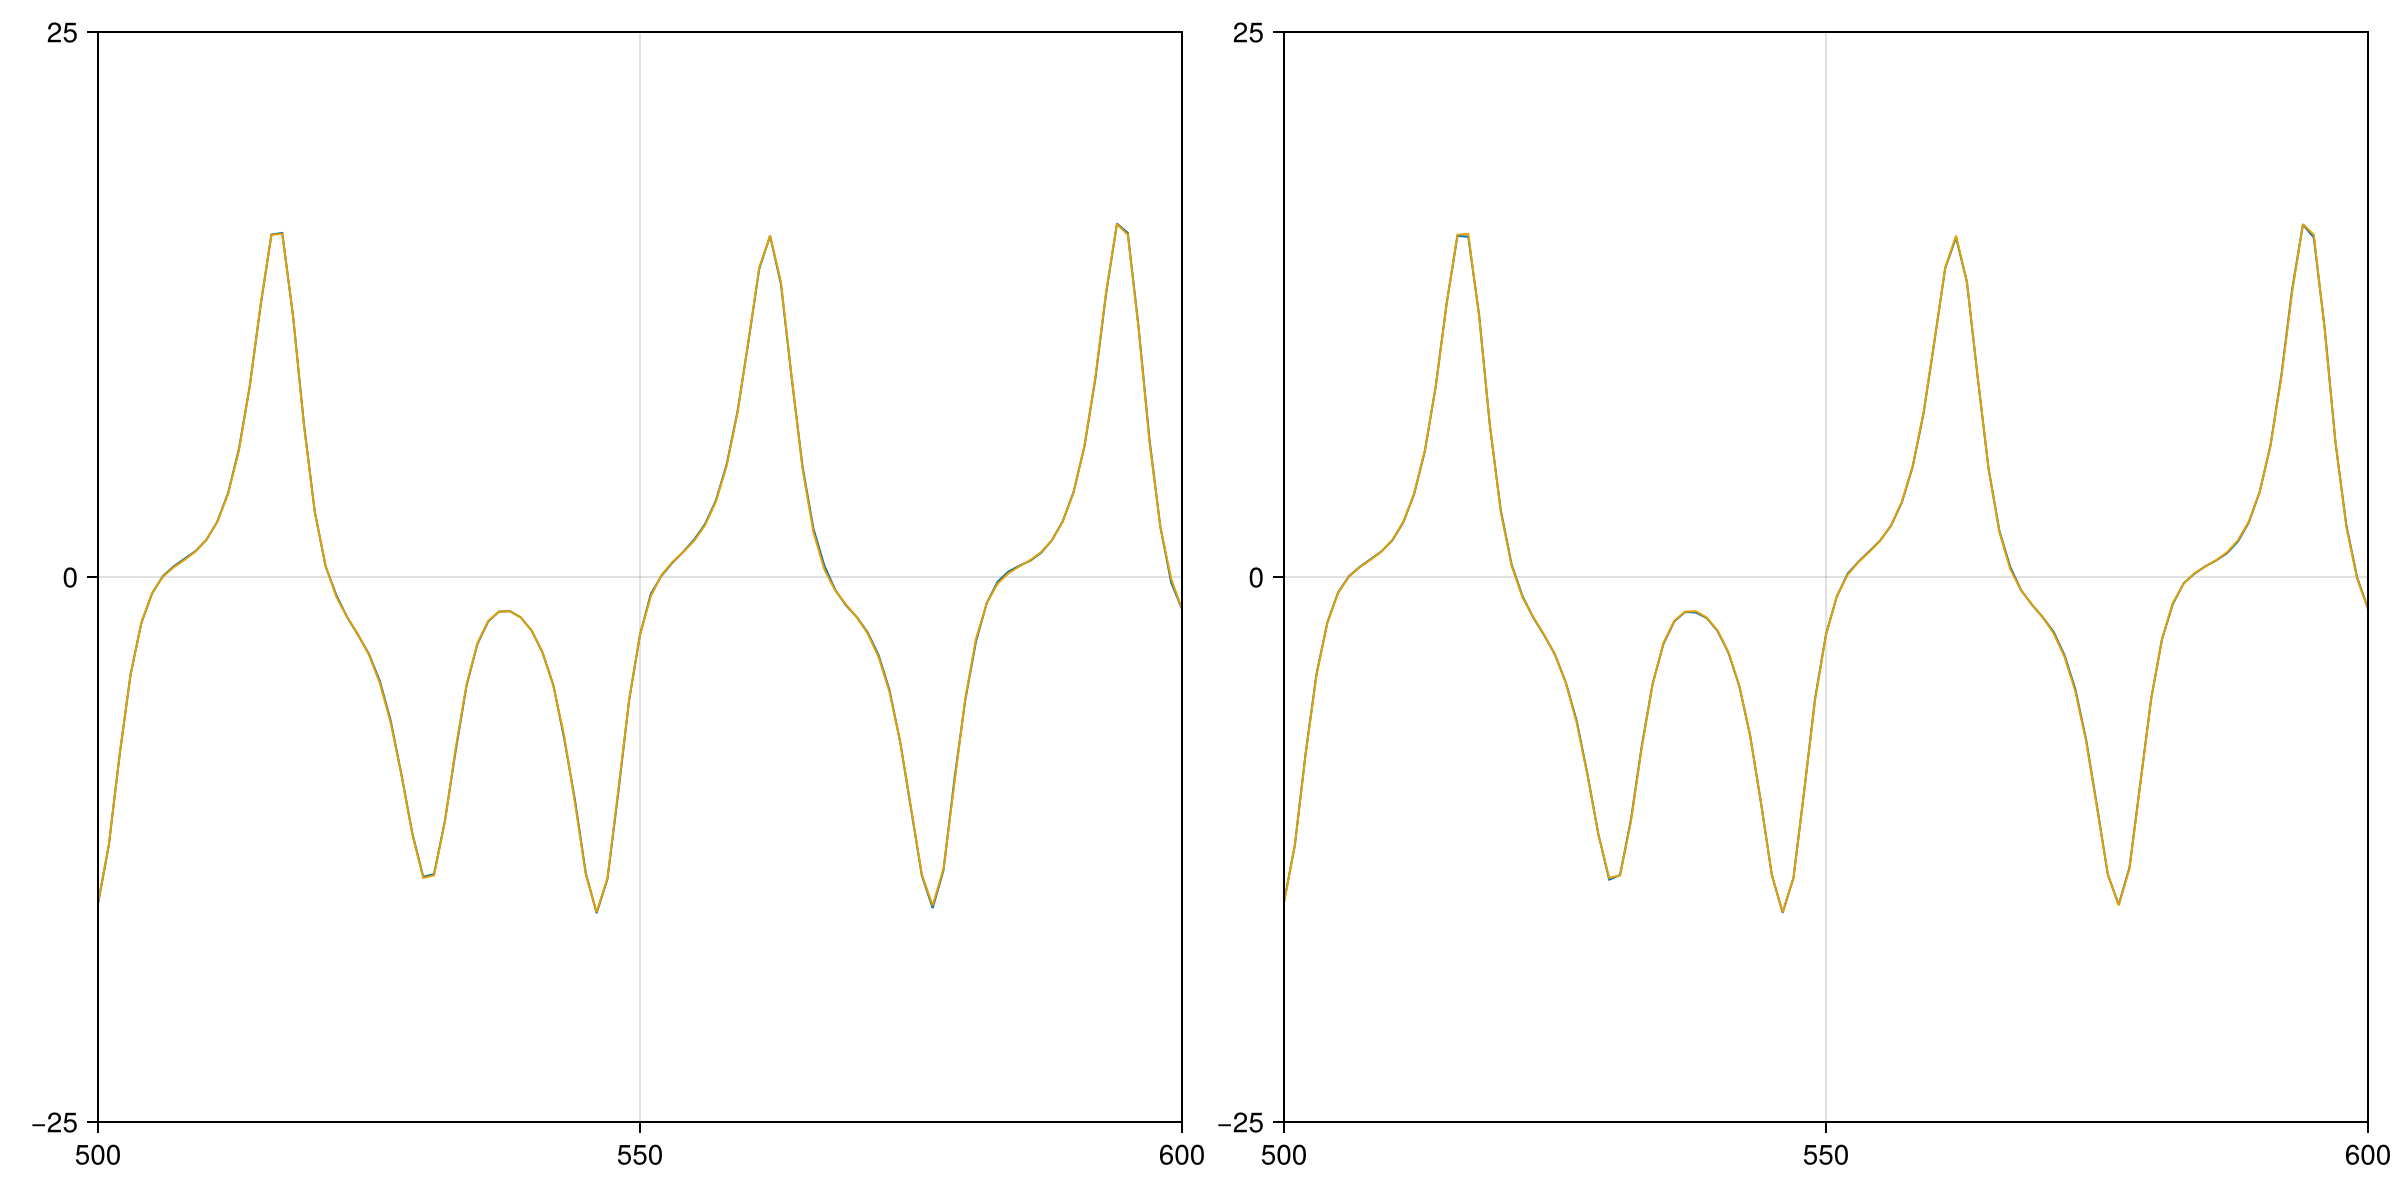

In [57]:
compare_preds(ON_preds, vanilla_preds, 500, 600, ignore_first=20)

## Freerun predictions

In [18]:
function create_pred_for_params_free_run(m; k = 100, d = k*0.05, ρ = 1.1, α = 1.0, η = 1/maximum(lo_train), β = 0.001, w = 1, τ = 1)
    window_size = (m-1)*τ
    
    part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
    trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
    num_partitions = length(unique_partitions_train)
    trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

    ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, part_connection=0.05, ON_part_adjacency=trans_adjacency_map)

    R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train)


    part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
    
    preds = [lo_test[1]]
    state = train_states[end,:]
    for i in 2:length(part_symbols_test)
        one_freerun_pred, one_freerun_state = one_step_pred(preds[i-1], ESN_params, R, S = state, partition_symbols=part_symbols_test[i])
        one_onestep_pred, one_onestep_state = one_step_pred(lo_test[i-1], ESN_params, R, S = state, partition_symbols=part_symbols_test[i])
        pred = one_freerun_pred[1]
        state = one_onestep_state[1,:]
        # state = one_freerun_state[1,:]
        if part_symbols_test[i] == nothing
            break
            # This fills in the ends where there might not be any partition symbols
            # push!(preds, lo_test[i])
            # continue
        end
        push!(preds, pred)
    end
    
    return(preds)
end

create_pred_for_params_free_run (generic function with 1 method)

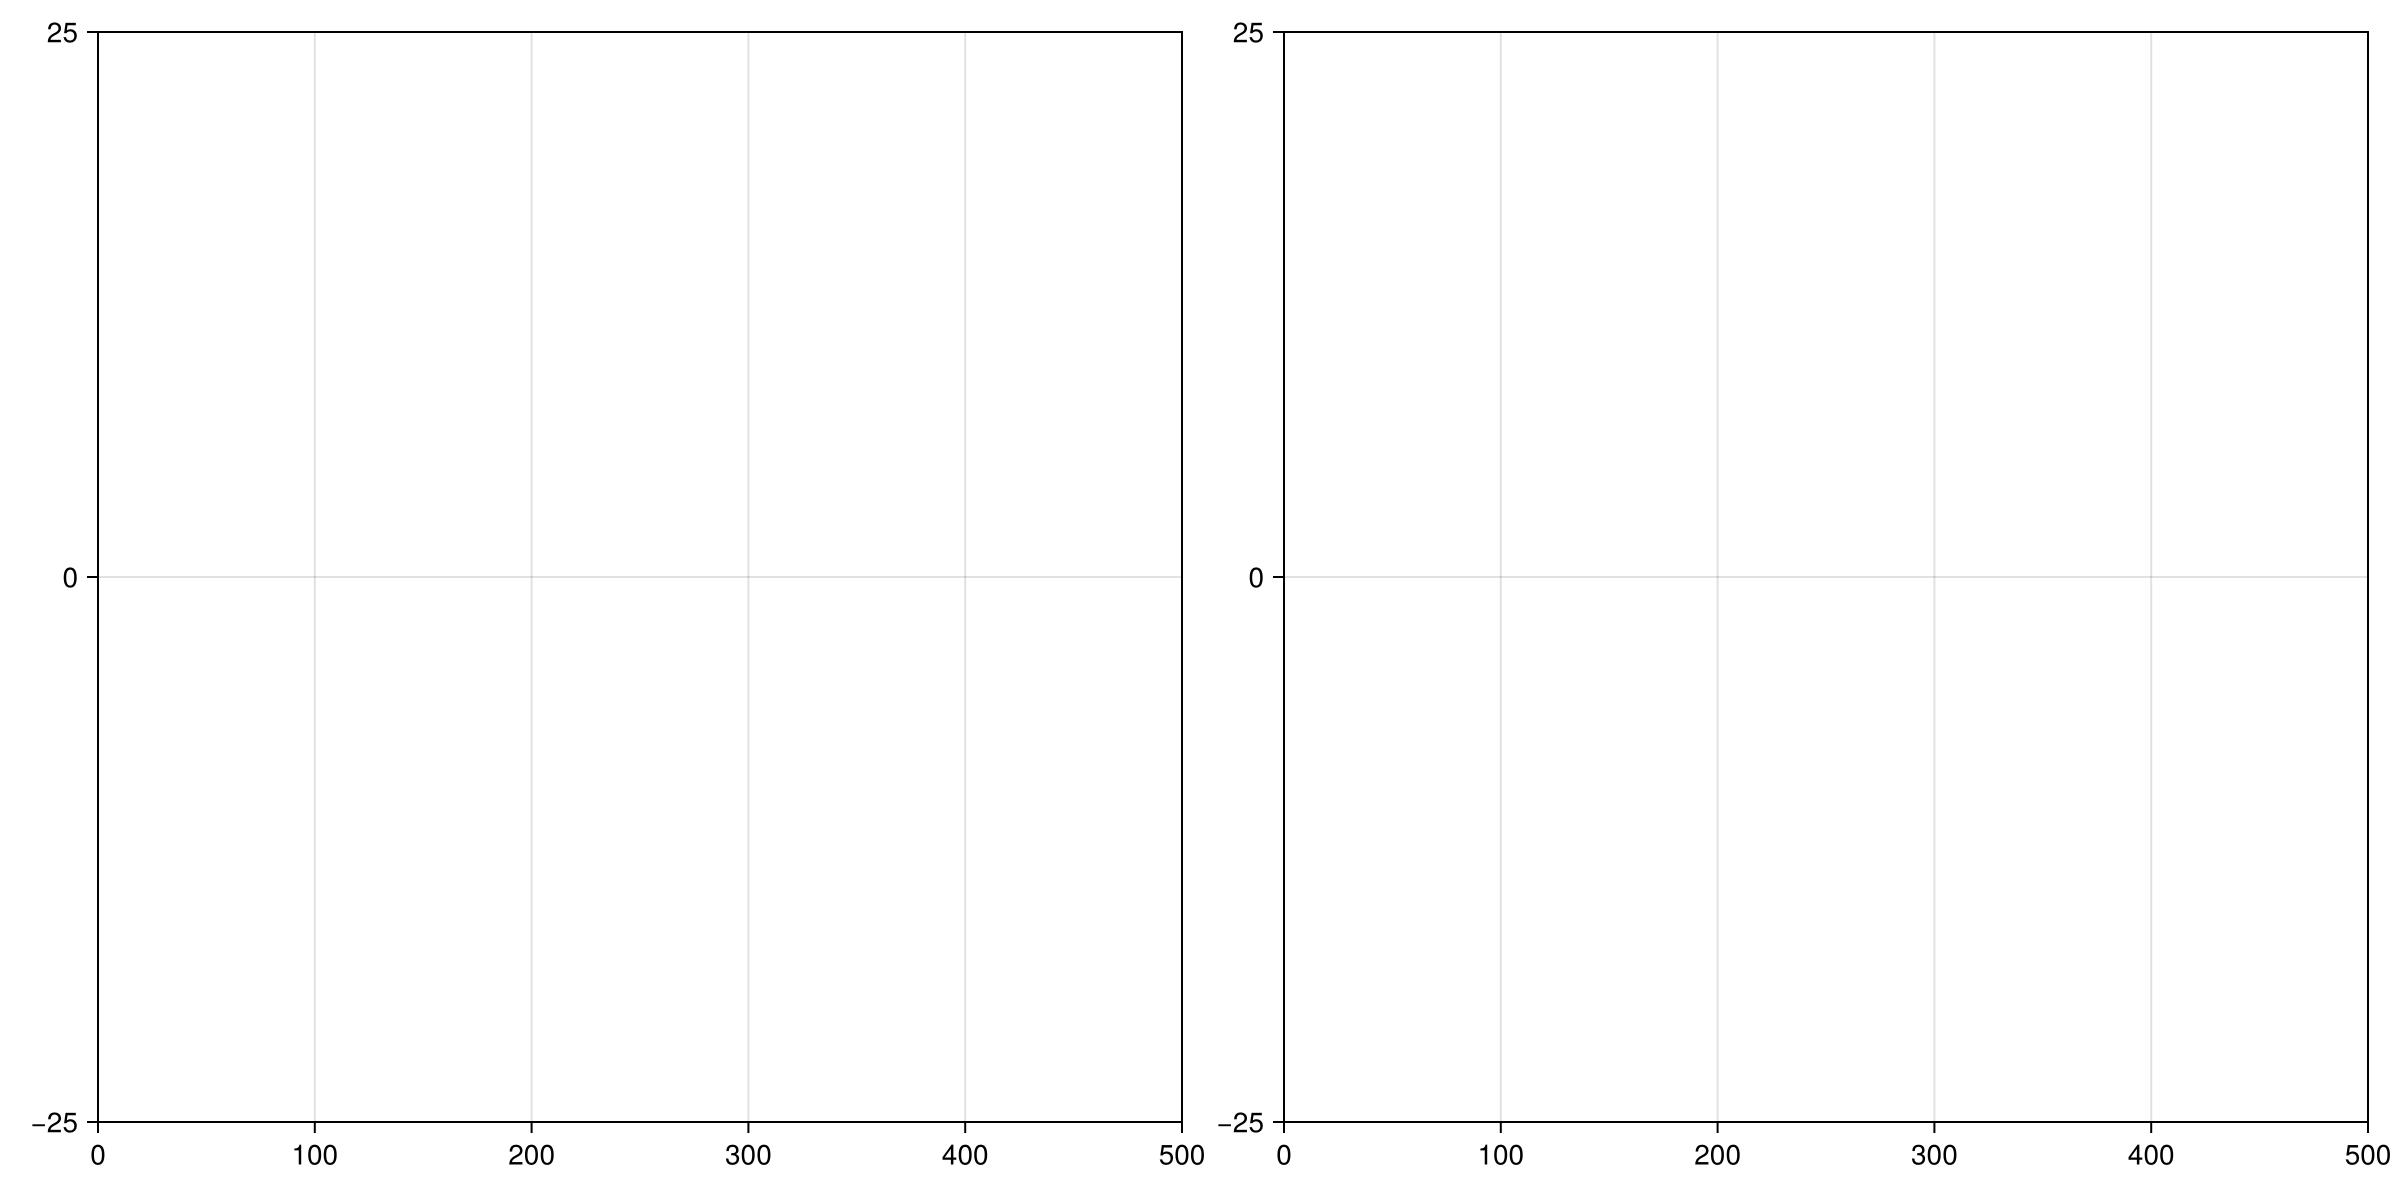

In [32]:
ON_preds_freerun = create_pred_for_params_free_run(4; k = 100)
vanilla_preds_freerun = create_pred_for_params_free_run(1; k = 400)

compare_preds(ON_preds_freerun, vanilla_preds_freerun, 0, 500, calculate_error=false)

## Multi step predictions

In [20]:
function multi_step_pred(initial_value, sub_part_symbols_test, state, R, ESN_params)
    pred, state = initial_value, state
    preds = [pred]
    
    for symbol in sub_part_symbols_test
        one_pred, one_state = one_step_pred(pred, ESN_params, R, S = state, partition_symbols=symbol)
        pred = one_pred[1]
        state = one_state[1,:]
        push!(preds, pred)
    end
    
    return(preds, state)
end

function create_pred_for_params_multi_step(m, chunk_length; k = 100, d = k*0.05, ρ = 1.1, α = 1.0, η = 1/maximum(lo_train), β = 0.001, w = 1, τ = 1)
    window_size = (m-1)*τ
    
    part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
    trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
    num_partitions = length(unique_partitions_train)
    trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

    ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, part_connection=0.1, ON_part_adjacency=trans_adjacency_map)

    R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train)

    part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
    
    preds = []
    current_state = train_states[end,:]
    current_true_value = lo_train[end]
    i = 1
    while i+chunk_length-1 < length(part_symbols_test)
        new_preds, _ = multi_step_pred(current_true_value, part_symbols_test[i:i+chunk_length-2], current_state, R, ESN_params)
        preds = vcat(preds, new_preds)

        states = run_ESN(lo_test[i:i+chunk_length-1], ESN_params; S = current_state, partition_symbols=part_symbols_test[i:i+chunk_length-1])
        current_state = states[1,:]
        
        current_true_value = lo_test[i+chunk_length-1]
        
        i = i + chunk_length
    end
    
    return(preds[2:end])
end

create_pred_for_params_multi_step (generic function with 1 method)

In [22]:
# ESN_params.V_rec

In [23]:
# mask_V_in_for_partition([1,1,1,1,1,1,1,1,1], 2, 3, 3)

In [24]:
# function test_mask_func(V_in, partition, k, num_partitions)
#     masked_V_in = zeros(k*num_partitions, num_partitions)
    
#     for part_i in 1:num_partitions
#         masked_V_in[(part_i-1)*k+1:part_i*k, part_i] .= 1
#     end
    
#     masked_V_in = masked_V_in*one_hot_encode(partition, num_partitions).*V_in
    
#     return(masked_V_in)
# end

# stts[50,:]
# # test_mask(stts[50,:], 1, )

In [25]:
ON_preds_multistep = create_pred_for_params_multi_step(3, 2; k = 400)
vanilla_preds_multistep = create_pred_for_params_multi_step(1, 2; k = 1200);

Ordinal network reservoir prediction RMSE: 1.6426654609401354
Vanilla prediction RMSE: 0.9291371833606827
Ordinal network reservoir prediction turning partition RMSE: 4.68094319371205
Vanilla prediction turning partition RMSE: 3.112945394665287


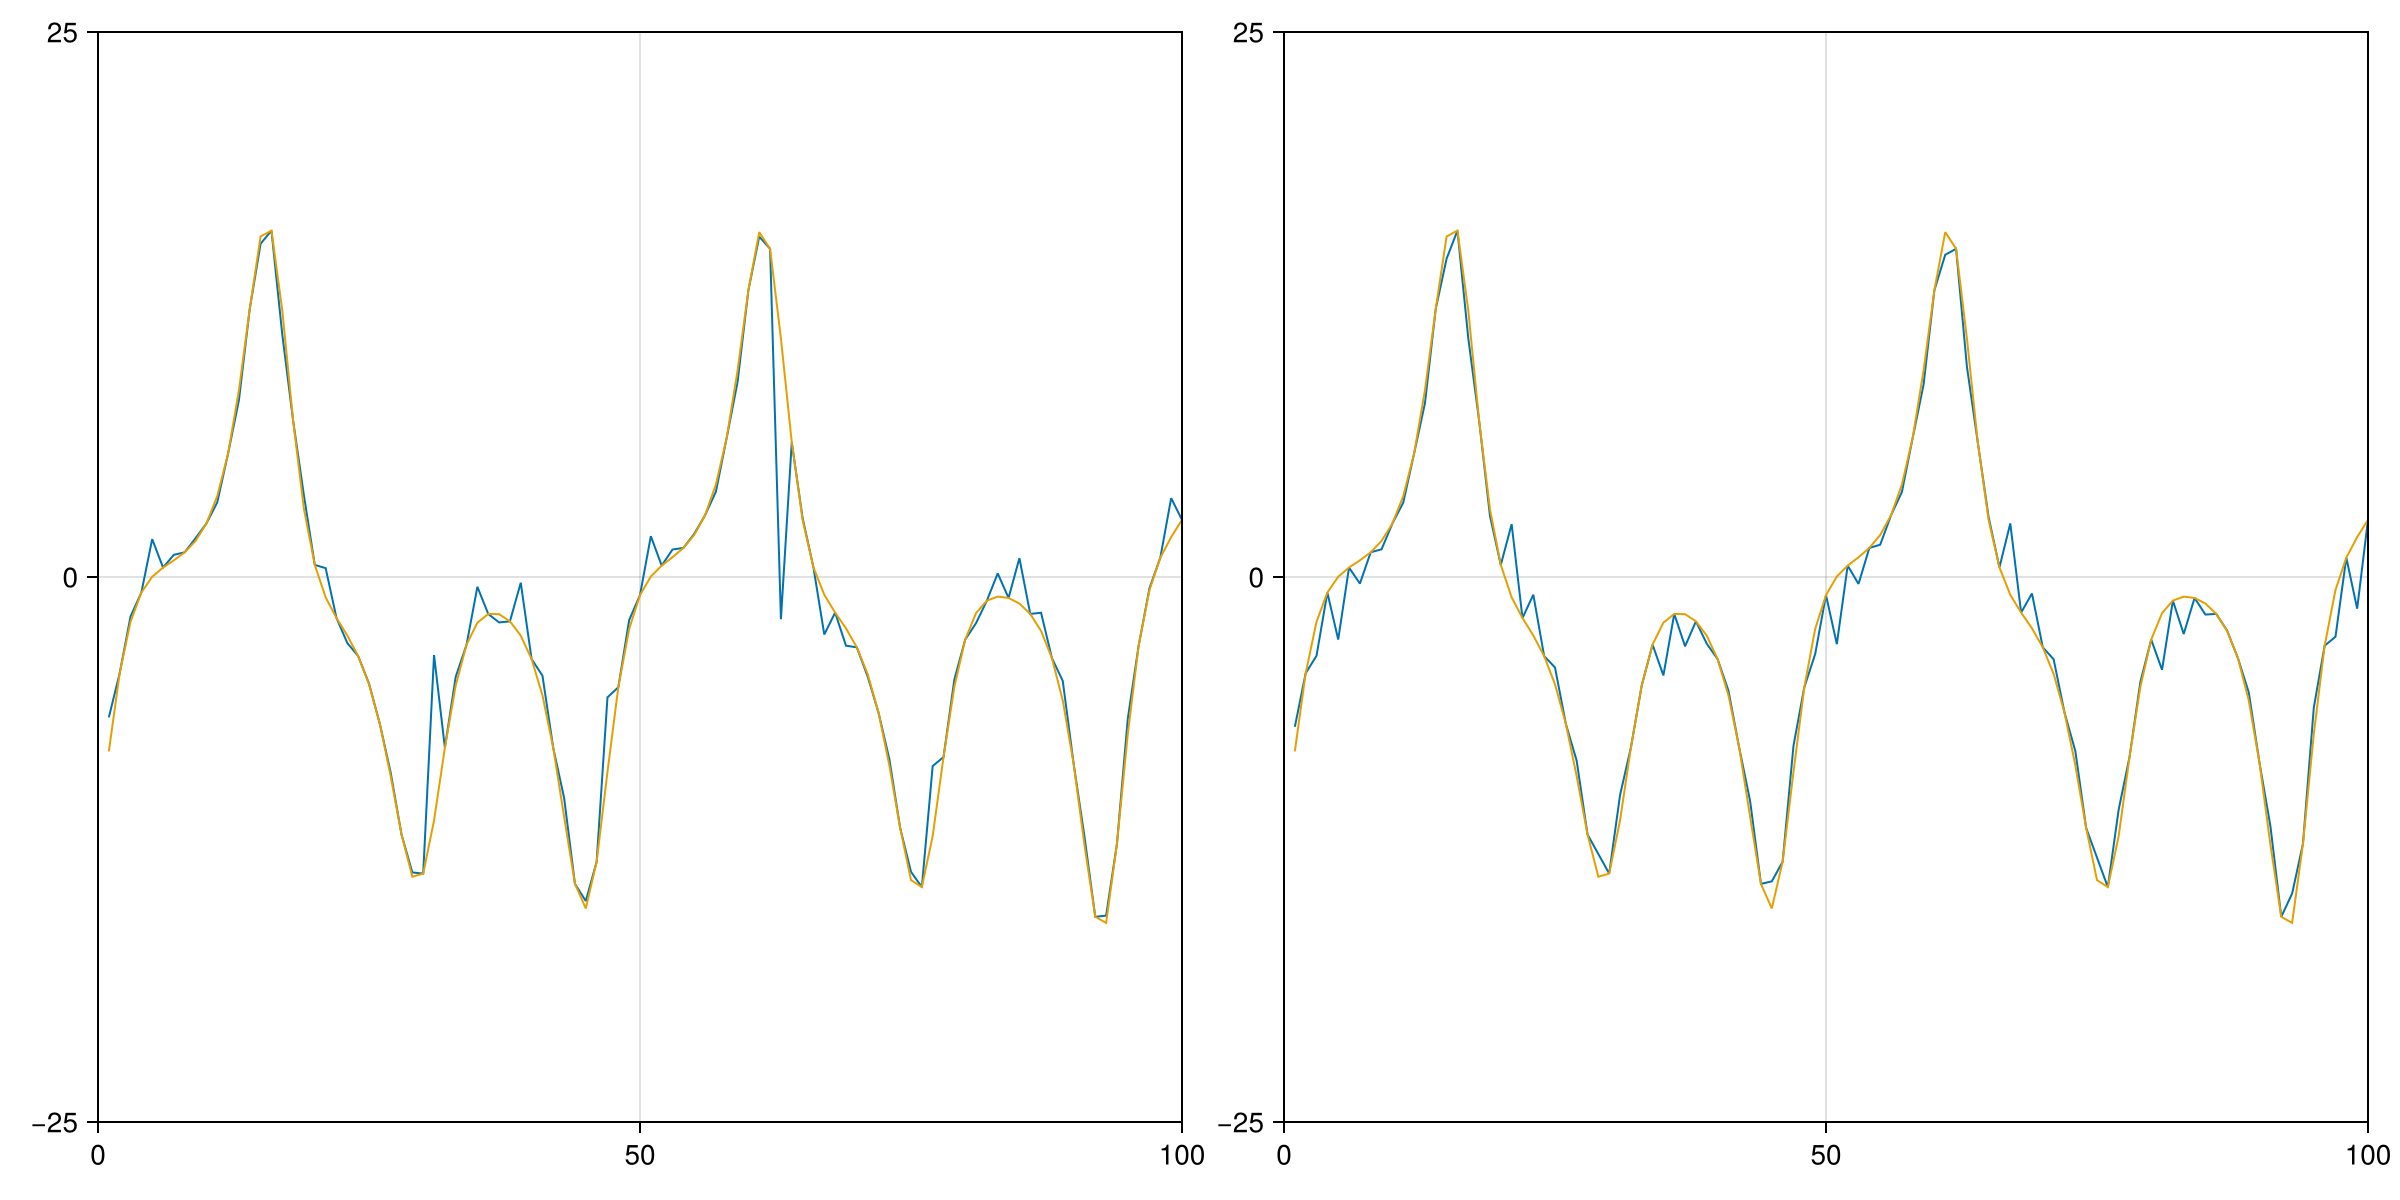

In [26]:
compare_preds(ON_preds_multistep, vanilla_preds_multistep, 0, 100, ignore_first=20, offset=0)

In [27]:
ON_preds_multistep = create_pred_for_params_multi_step(3, 3; k = 400)
vanilla_preds_multistep = create_pred_for_params_multi_step(1, 3; k = 1200);

Ordinal network reservoir prediction RMSE: 6.937057480243788
Vanilla prediction RMSE: 5.710465702125283
Ordinal network reservoir prediction turning partition RMSE: 14.776209501804008
Vanilla prediction turning partition RMSE: 5.754687399326348


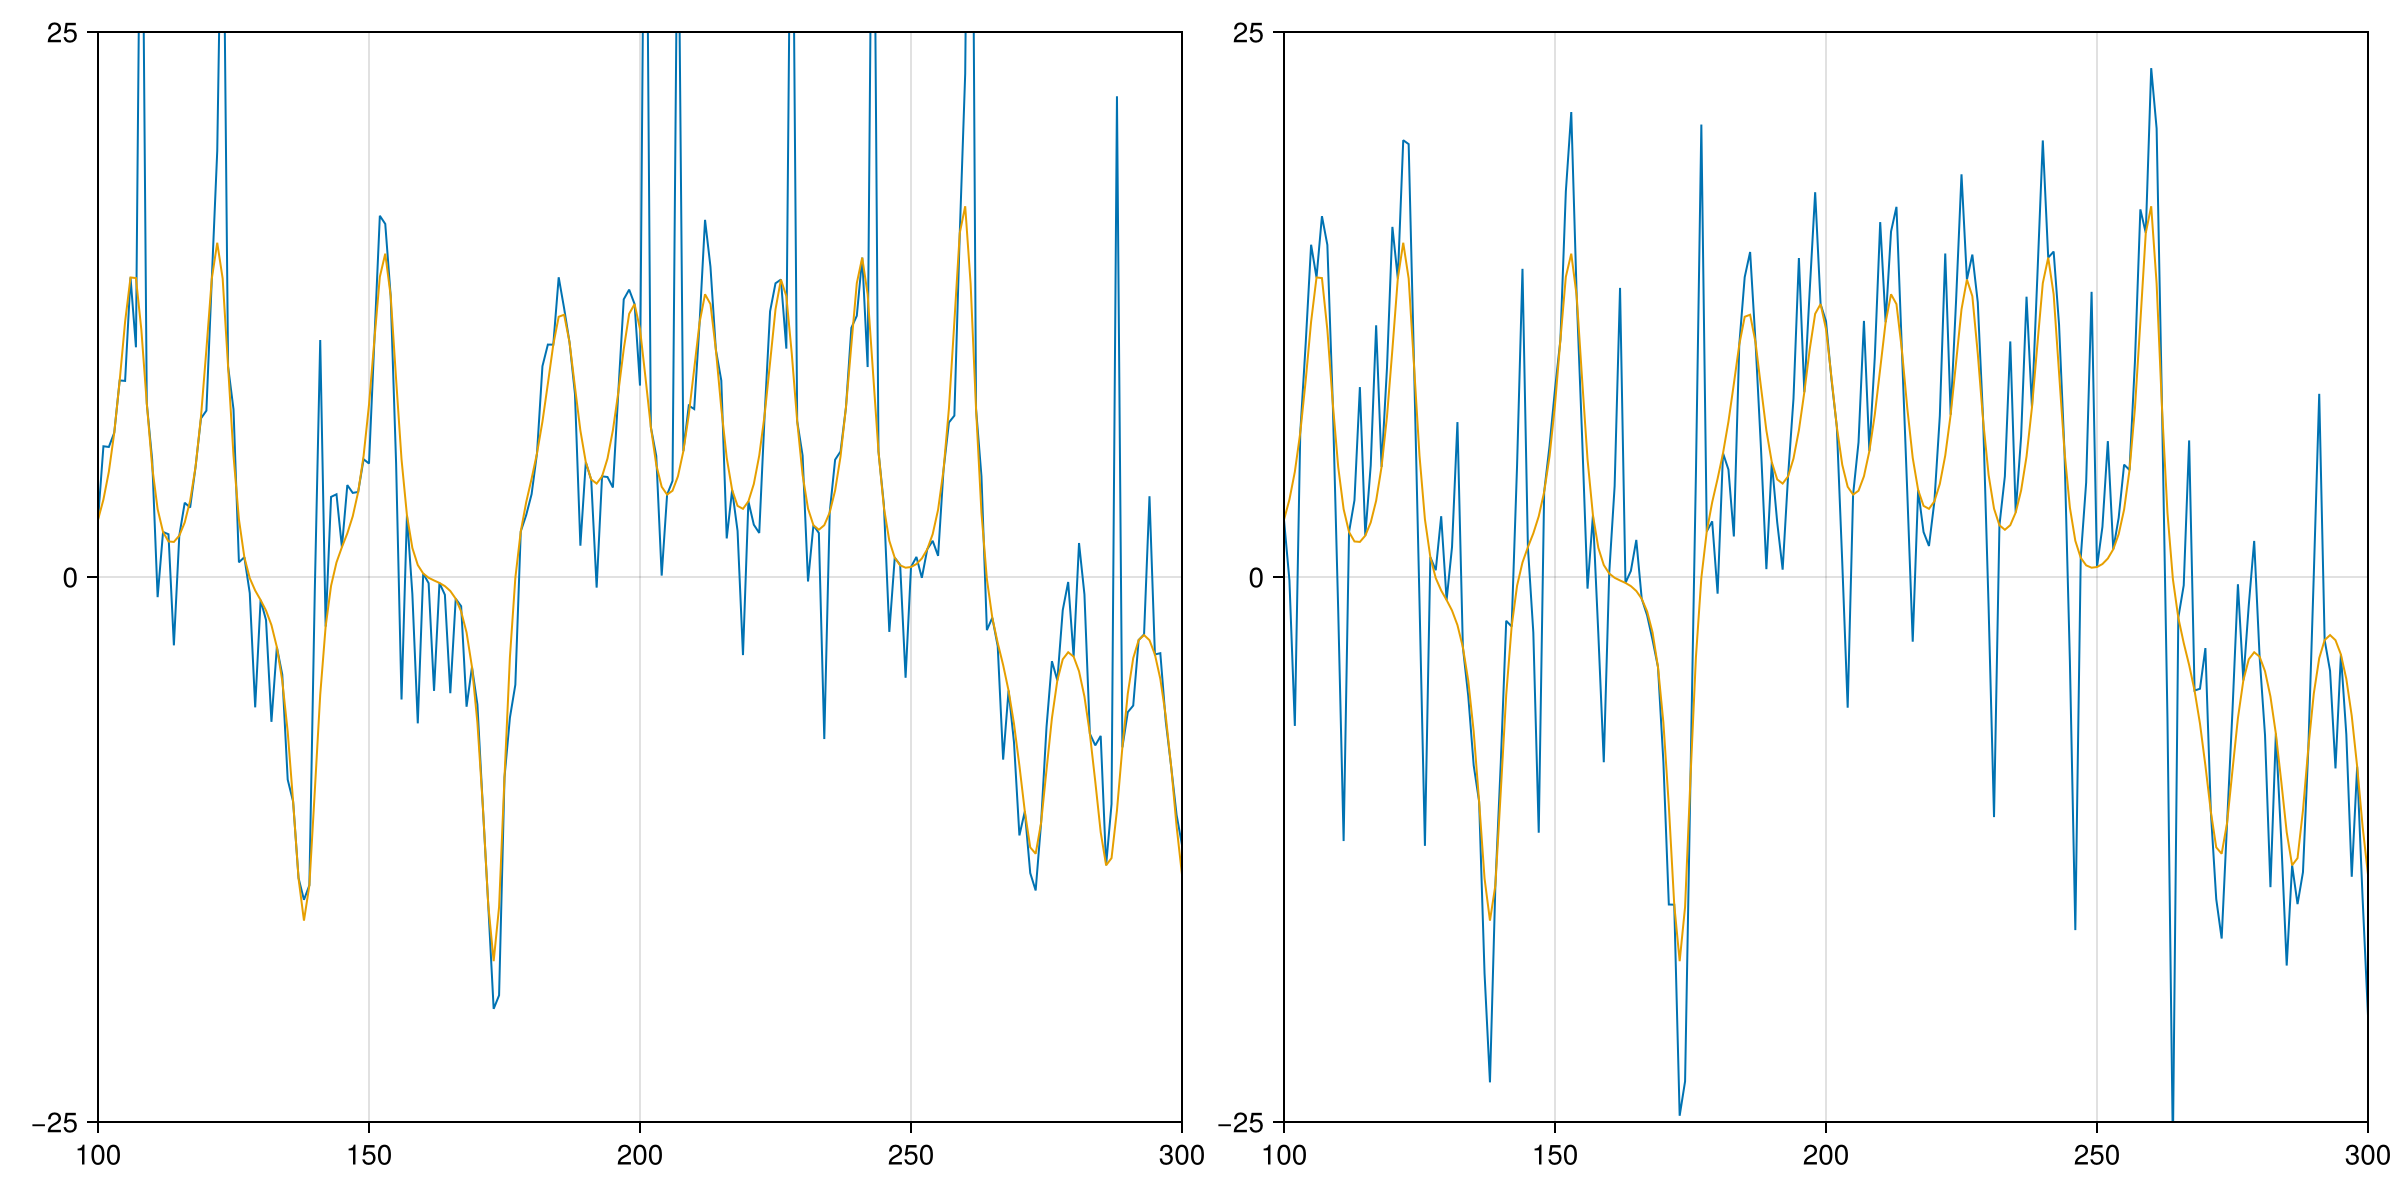

In [28]:
compare_preds(ON_preds_multistep, vanilla_preds_multistep, 100, 300, ignore_first=20, offset=0)

In [29]:
ON_preds_multistep = create_pred_for_params_multi_step(3, 4; k = 400)
vanilla_preds_multistep = create_pred_for_params_multi_step(1, 4; k = 1200);

Ordinal network reservoir prediction RMSE: 21.526147063268912
Vanilla prediction RMSE: 14.484932783313983
Ordinal network reservoir prediction turning partition RMSE: 46.70053178689948
Vanilla prediction turning partition RMSE: 10.712847101815347


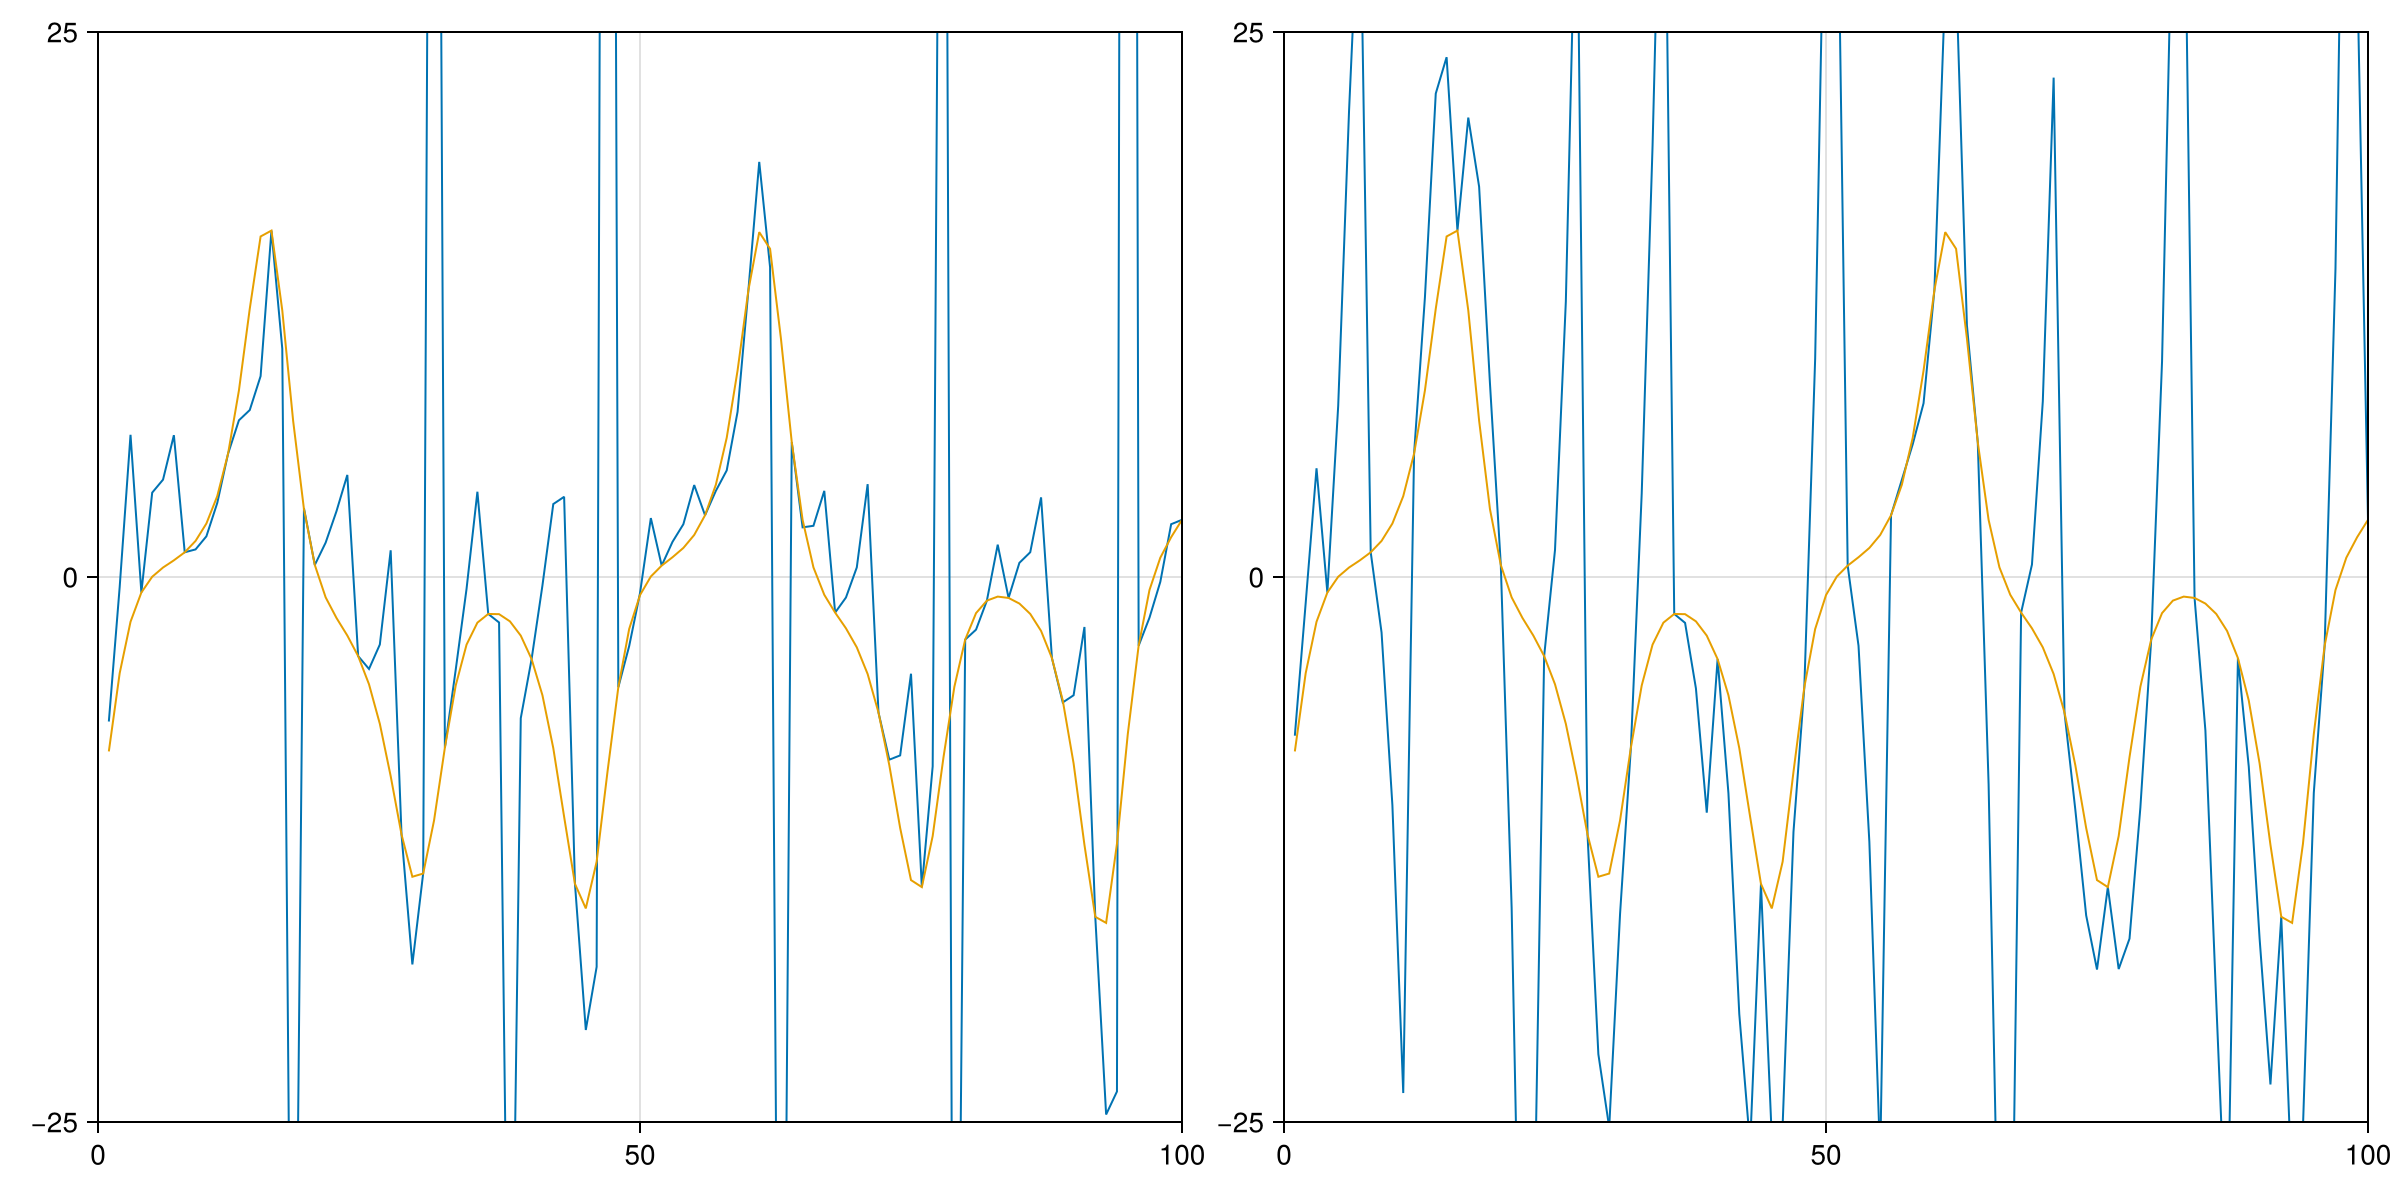

In [30]:
# compare_preds(ON_preds_multistep, vanilla_preds_multistep, 100, 300, ignore_first=20, offset=0)
compare_preds(ON_preds_multistep, vanilla_preds_multistep, 0, 100, ignore_first=20, offset=0)

In [31]:
test_part = create_ordinal_partition(lo_train, 4, 1, 1)
ON_trans_probs = find_probs(test_part)

UndefVarError: UndefVarError: `find_probs` not defined

In [38]:
# if we want it to train better, then we should mask the states before the output rather than mask the readout vector

test_k = 3
test_parts = 3

states = ones(test_k*test_parts, test_k*test_parts)

part = 2

n1 = (part-1)*test_k+1
n2 = part*test_k

states[:,1:n1-1] .= 0
states[:,n2+1:end] .= 0
states[1:n1-1,:] .= 0 
states[n2+1:end,:] .= 0

states

9×9 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [21]:
stts[:,1]

8000-element Vector{Float64}:
  0.0
  0.0
  0.0
 -0.8855873768015823
 -0.8918694465853841
 -0.8945142606516204
 -0.8953824844888286
 -0.8644381421355106
 -0.8693768768236068
 -0.8644645216479642
  ⋮
 -0.8644468447313552
 -0.864444062505199
 -0.8644453447646411
 -0.8644445291123618
 -0.8644439682373585
 -0.8644437595177974
 -0.8724980386251802
 -0.8759914136443797
 -0.8811643796292388

In [43]:
function test_mask_states!(states, partition_symbols, k, num_partitions)
    for part_i in 1:num_partitions
        states[(part_i-1)*k+1:part_i*k, partition_symbols[part_i]] .= 0
    end
end

state = ones(test_k*test_parts, test_k*test_parts)
states = [state, state, state]

# mask_states!(states, [1,2,3], test_k, test_parts)
states[][1:2,1] .= 0

states[1]

MethodError: MethodError: Cannot `convert` an object of type Int64 to an object of type Matrix{Float64}

Closest candidates are:
  convert(::Type{Array{T, N}}, !Matched::StaticArraysCore.SizedArray{S, T, N, N, Array{T, N}}) where {S, T, N}
   @ StaticArrays ~/.julia/packages/StaticArrays/MSJcA/src/SizedArray.jl:88
  convert(::Type{Array{T, N}}, !Matched::StaticArraysCore.SizedArray{S, T, N, M, TData} where {M, TData<:AbstractArray{T, M}}) where {T, S, N}
   @ StaticArrays ~/.julia/packages/StaticArrays/MSJcA/src/SizedArray.jl:82
  convert(::Type{Array{S, N}}, !Matched::PooledArrays.PooledArray{T, R, N}) where {S, T, R, N}
   @ PooledArrays ~/.julia/packages/PooledArrays/Vy2X0/src/PooledArrays.jl:499
  ...
